# Analysis and record for ED2-tree-ring project

In [1]:
import os
os.getcwd()
data_dir = './Data/'

1. Model setup

We need to configure PFTs for the Thailand site based on field data (and literature review)
This section will generate a table of key functional traits for PFTs in ED2

In addition we need to decide whether to use two or three PFTs (currently leaned toward 2)

1.0 Number of PFTs

We compare the growth-size relationship of the five species and decide how to bin them together


In [2]:
import numpy as np
import pandas as pd
import proplot as pplt



In [3]:
def GMM(x,a,b,k):
    '''
        Generalized michaelist-menton equation
    '''

    return a * np.power(x,b) / (k + np.power(x,b))

from scipy.optimize import curve_fit

In [4]:

# read observed tree ring
# save them into df_tr_obs
df_tr_obs = pd.read_csv(f'{data_dir}HKK_treering.csv')

# df_tr_obs = df_tr_obs[df_tr_obs.Species.isin(['TOONCI','MELIAZ','CHUKTA','AFZEXY'])]

# add PFT
pft_dict = {
    'TOONCI' : 2,
    'MELIAZ' : 2,
    'CHUKTA' : 4,
    'AFZEXY' : 4,
    'NEOLOB' : 4, #Neolitsea is not included in the analysis
}

df_tr_obs = df_tr_obs.assign(PFT=[pft_dict[row.Species] for i, row in df_tr_obs.iterrows()])

# rename the columns so that it matches the standarize_treering
df_tr_obs = df_tr_obs.rename(columns={'BAIdbh' : 'BAI'})

# only use 1950 to 2010
df_tr_obs = df_tr_obs.query('Year <= 2010 & Year >= 1900')


140.39719899604492 1.5805018216781446 574.739684679628
70.40829506254325 2.800590904913427 964.7246079268385
56.89642908620293 2.4419555270963986 3056.892032849838
52.78080798975837 3.396821363508925 19345.4317613861
682.1664569181702 1.4383966666327381 4071.407989905885


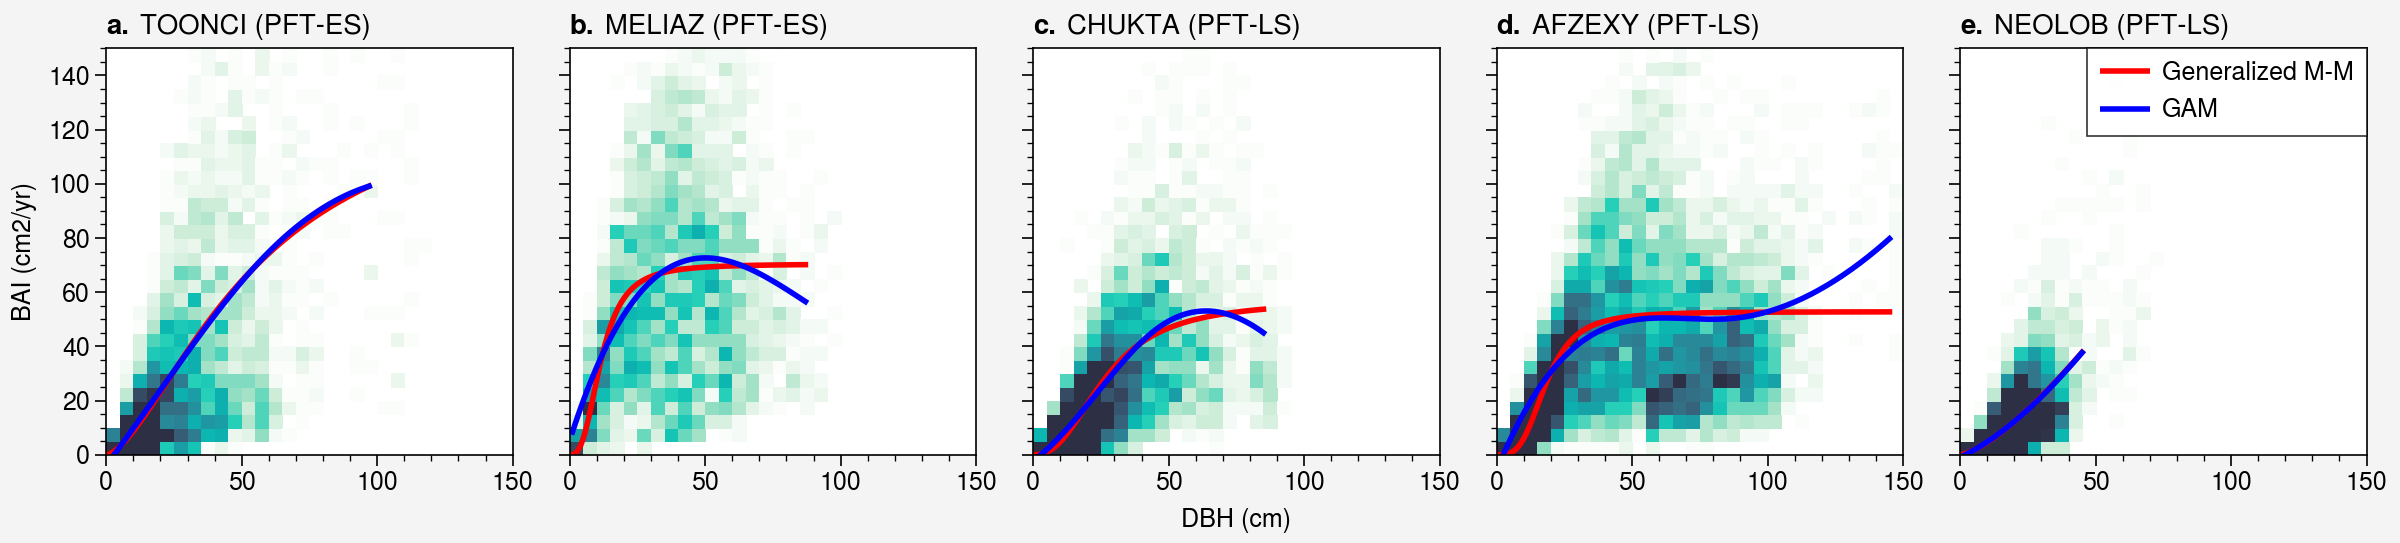

In [94]:
# function to generate standarized tree ring using RCS
from pygam import LinearGAM,s,l, GAM, GammaGAM
from scipy.stats import binned_statistic_2d
n_splines = 5 # use gridsearch
# loop over each sp to generate a GAM model
gams = []
gams_ma = []  # using moving average values for gam
sp_list = ['TOONCI','MELIAZ','CHUKTA','AFZEXY','NEOLOB']
dbh_max = []
popts = []

fig, axes = pplt.subplots(ncols=5,nrows=1,figwidth=12)
for i, ax in enumerate(axes):
    # loop over species
    sp = sp_list[i]
    sp_mask = df_tr_obs.Species == sp
    bai_mask = df_tr_obs.BAI > 0.
    df_sp = df_tr_obs[sp_mask & bai_mask][['dbh','BAI']].dropna()
 
    # first generate heatmap
    binx = np.arange(0,200,5)
    biny = np.arange(0,500,5)

    ret = binned_statistic_2d(df_sp.dbh.values.ravel(),
                              df_sp.BAI.values.ravel(),
                              None,
                              'count',
                              bins=[binx,biny])
    Y, X = np.meshgrid(biny,binx)
    Z = ret.statistic
    Z[Z == 0] = np.nan
    
    ax.pcolormesh(X,Y,Z,vmin=0,vmax=40,cmap='Marine',N=40,symmetric=False)    

    title_str = sp
    if i in [0,1]:
        title_str += ' (PFT-ES)'
    else:
        title_str += ' (PFT-LS)'

    ax.format(title=title_str)

    # add regression line
    dbh_max.append(np.nanpercentile(df_sp.dbh.values,99.))

    popt, pcov = curve_fit(GMM,
             df_sp.dropna()[['dbh']].values.ravel()
            ,df_sp.dropna()[['BAI']].values.ravel()
            ,bounds=([0,0,1],[10000,10,100000]))
    
    popts.append(popt)

    dbh_range = np.arange(1,dbh_max[i])
    a,b,k = popt
    print(a,b,k)
    #bai_predict = _gam.predict(dbh_range)
    bai_predict = GMM(dbh_range,a,b,k)
    hs = []
    h, = ax.plot(dbh_range,bai_predict,c='r',lw=2.,label='Generalized M-M')
    hs.append(h)

    gam_growth = LinearGAM(s(0,n_splines=5)).fit(
             df_sp.dropna()[['dbh']].values
            ,df_sp.dropna()[['BAI']].values)
        
        # lambda is 0.6 by default
    
    gams.append(gam_growth)
    bai_predict = gam_growth.predict(dbh_range)
    h, = ax.plot(dbh_range,bai_predict,c='b',lw=2.,label=f'GAM')
    hs.append(h)
    
    if i == len(sp_list)-1:
        ax.legend(hs,ncols=1,loc='ur')




axes.format(xlim=(0,150),ylim=(0.,150),xlabel='DBH (cm)', ylabel='BAI (cm2/yr)',abc='a.',titleloc='l')
fig.savefig('./Figures/growth_size_sp.png',dpi=300)

1.1 Height allometry

Read field observations to set DBH-height relationship.
Compare each species' allometry, 3 PFT allometry, and 2 PFT allometry

In [7]:
import numpy as np
import pandas as pd
import proplot as pplt
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [8]:
# first read the field data
hkk_df = pd.read_excel(f'{data_dir}TROFOCLIM_ZUIDEMA_FIELD.data4.0_Thailand_ONLY.xlsx')
dbh_data = hkk_df['DBH'].values # cm
h_data = hkk_df['Height'].values # m
sp_data = hkk_df['Sp.code'].values
sp_list = ['TOONCI','MELIAZ','CHUKTA','AFZEXY','NEOLOB']

# get PFT and wood density
PFT_data = np.zeros_like(h_data,dtype=int)
rho_data = np.zeros_like(h_data,dtype=float)

for i, sp in enumerate(sp_data):
    if sp in ['CHUKTA','AFZEXY','NEOLOB']:
        PFT_data[i] = 4
        rho_data[i] = 0.8
    elif sp in ['TOONCI','MELIAZ']:
        PFT_data[i] = 2
        rho_data[i] = 0.6

In [9]:
reg_list = []
for i, PFT in enumerate([2,4]):
    _mask = PFT_data == PFT

    reg_mask = _mask & (~np.isnan(dbh_data)) & (~np.isnan(h_data))
    reg_x = np.log(dbh_data[reg_mask])
    reg_y = np.log(h_data[reg_mask])
    reg_res = sm.OLS(reg_y,sm.add_constant(reg_x)).fit()

    reg_list.append(reg_res)
    
    print(PFT)
    print(reg_res.summary())
    


2
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     422.5
Date:                Tue, 25 Jul 2023   Prob (F-statistic):           2.42e-45
Time:                        15:56:34   Log-Likelihood:                 96.774
No. Observations:                 151   AIC:                            -189.5
Df Residuals:                     149   BIC:                            -183.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5810      0.085     18.536      0

1.589147476209152 0.45940481749178286
1.5698539446232 0.4416298747031192


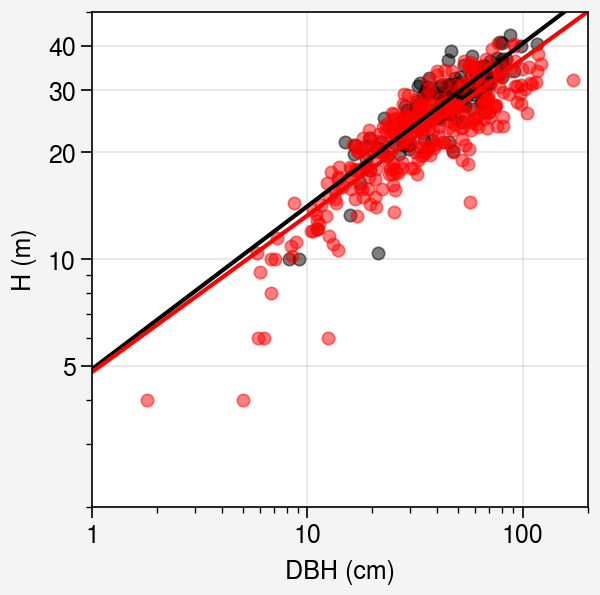

In [123]:
fig, ax = pplt.subplots(ncols=1,nrows=1,figwidth=3,share=False)
x_pred = np.arange(1,200)
data_mask = (PFT_data == 2) & (~np.isnan(dbh_data)) & (~np.isnan(h_data))
ax.scatter(dbh_data[data_mask],h_data[data_mask],c='k',s=20,alpha=0.5)
reg_res = reg_list[0]
mse = np.mean(reg_res.resid ** 2)
y_pred = np.exp(0.5 * mse + reg_res.params[0] + reg_res.params[1] * np.log(x_pred))
print(0.5*mse + reg_res.params[0],reg_res.params[1])
ax.plot(x_pred,y_pred,c='k')

data_mask = (PFT_data == 4) & (~np.isnan(dbh_data)) & (~np.isnan(h_data))
ax.scatter(dbh_data[data_mask],h_data[data_mask],c='r',s=20,alpha=0.5)
reg_res = reg_list[1]
mse = np.mean(reg_res.resid ** 2)
y_pred = np.exp(0.5 * mse + reg_res.params[0] + reg_res.params[1] * np.log(x_pred))
print(0.5*mse + reg_res.params[0],reg_res.params[1])
ax.plot(x_pred,y_pred,c='r')


ax.format(xlim=(1,200),xscale='log',ylim=(2,50),yscale='log',ylocator=[5,10,20,30,40],
          xlabel='DBH (cm)',ylabel='H (m)')

fig.savefig('./Figures/Fig_S_height_allometry.png',dpi=300)


1.2 Other functional traits

leaf turnoverate + wood density

Other traits will be based on Marcos's meta-analysis


In [11]:
df_trait = pd.DataFrame({})

df_trait['b1Ht'] = [1.589, 1.570]
df_trait['b2Ht'] = [0.459, 0.442]
df_trait['rho']  = [0.5, 0.75]
df_trait['leaf_turnover_rate'] = [1.5,0.5]

print(df_trait)

    b1Ht   b2Ht   rho  leaf_turnover_rate
0  1.589  0.459  0.50                 1.5
1  1.570  0.442  0.75                 0.5


2. Explorative observed tree ring analysis

Standardized tree ring and dC13

Calculate trend and CO2 beta

In [12]:
def std_tr(df_tr,n_splines=0):
    '''
        Input: raw treering data
        Need to have a column of dbh, BAI, Tree, Year
        return GMM results and df_tr_rcs
    '''
    # first sort all the data by year
    df_tr = df_tr.sort_values('Year')
    
    # first get all unique sp and tree_id values
    tree_list = df_tr.Tree.value_counts().index.values
    
    # create a df for output
    df_tr_rcs = df_tr.copy()
    df_tr_rcs = df_tr_rcs.assign(BAI_rcs=np.nan)
    
    # also create BAI40_eq (equivalent BAI at 40cm)
    df_tr_rcs = df_tr_rcs.assign(BAI40_eq=np.nan)
    
    # also create 10-year moving average BAI and Ci
    df_tr_rcs = df_tr_rcs.assign(BAI_ma10=np.nan)
    df_tr_rcs = df_tr_rcs.assign(BAI_ma10_rcs=np.nan)
    
    # loop over each tree to calcualte moving average
    for itree, tree in enumerate(tree_list):
        # select one tree, this should already sorted by year
        
        df_tree = df_tr_rcs[df_tr_rcs.Tree == tree].sort_values('Year')
        
        BAI_ma10 = df_tree['BAI'].rolling(10).mean()
        
        df_tr_rcs.loc[df_tr_rcs.Tree == tree,'BAI_ma10'] = BAI_ma10.values
    
    # loop over each sp to generate a GMM model
    bai_mask = df_tr_rcs.BAI > 0.
    
    df_sp = df_tr_rcs[bai_mask][['dbh','BAI']]

        
    popt, pcov = curve_fit(GMM,
        df_sp.dropna().dbh.values.ravel()
        ,df_sp.dropna().BAI.values.ravel()
        ,bounds=([0,0,1],[10000,10,100000]))

    a,b,k = popt
    bai_predict = GMM(df_sp.dbh,a,b,k)
 
       
    # calculate RCS 
    #gam_bai = np.exp(gam_growth.predict(np.log(df_sp.dbh)))
    #gam_bai = gam_growth.predict(df_sp.dbh)
        
    tr_rcs = np.log(df_sp.BAI.values / bai_predict)
    bai40_eq = df_sp.BAI.values / bai_predict * GMM(40.,a,b,k)
        
    # save tr_rcs
    df_tr_rcs.loc[bai_mask,'BAI_rcs'] = tr_rcs
    df_tr_rcs.loc[bai_mask,'BAI40_eq'] = bai40_eq
        
        
    ## using BAI_ma10
    df_sp = df_tr_rcs[bai_mask][['dbh','BAI_ma10']]

    popt_ma, pcov = curve_fit(GMM,
        df_sp.dropna().dbh.values.ravel()
        ,df_sp.dropna().BAI_ma10.values.ravel()
        ,bounds=([0,0,1],[10000,10,100000]))

    a,b,k = popt_ma
    bai_ma10_predict = GMM(df_sp.dbh,a,b,k)
       
    tr_rcs = np.log(df_sp.BAI_ma10.values / bai_ma10_predict)
        
    # save tr_rcs
    df_tr_rcs.loc[bai_mask,'BAI_ma10_rcs'] = tr_rcs
        
    return (df_tr_rcs,popt, popt_ma) 


(3410, 11)
[ 6.57234854e+00 -3.47750180e-03]
[2.14543224e-06 6.90058645e-07]
(3139, 11)
[ 1.91490038e+01 -9.71893733e-03]
[3.57628963e-44 5.87396401e-45]
(6882, 11)
[ 1.22459727e+01 -6.23539803e-03]
[3.00655966e-55 5.91753391e-56]
(7345, 11)
[-1.19668582e+00  5.63090364e-04]
[0.03180023 0.04662965]
(8084, 11)
[ 7.07897696e+00 -3.67917696e-03]
[2.23780475e-27 8.90397328e-29]


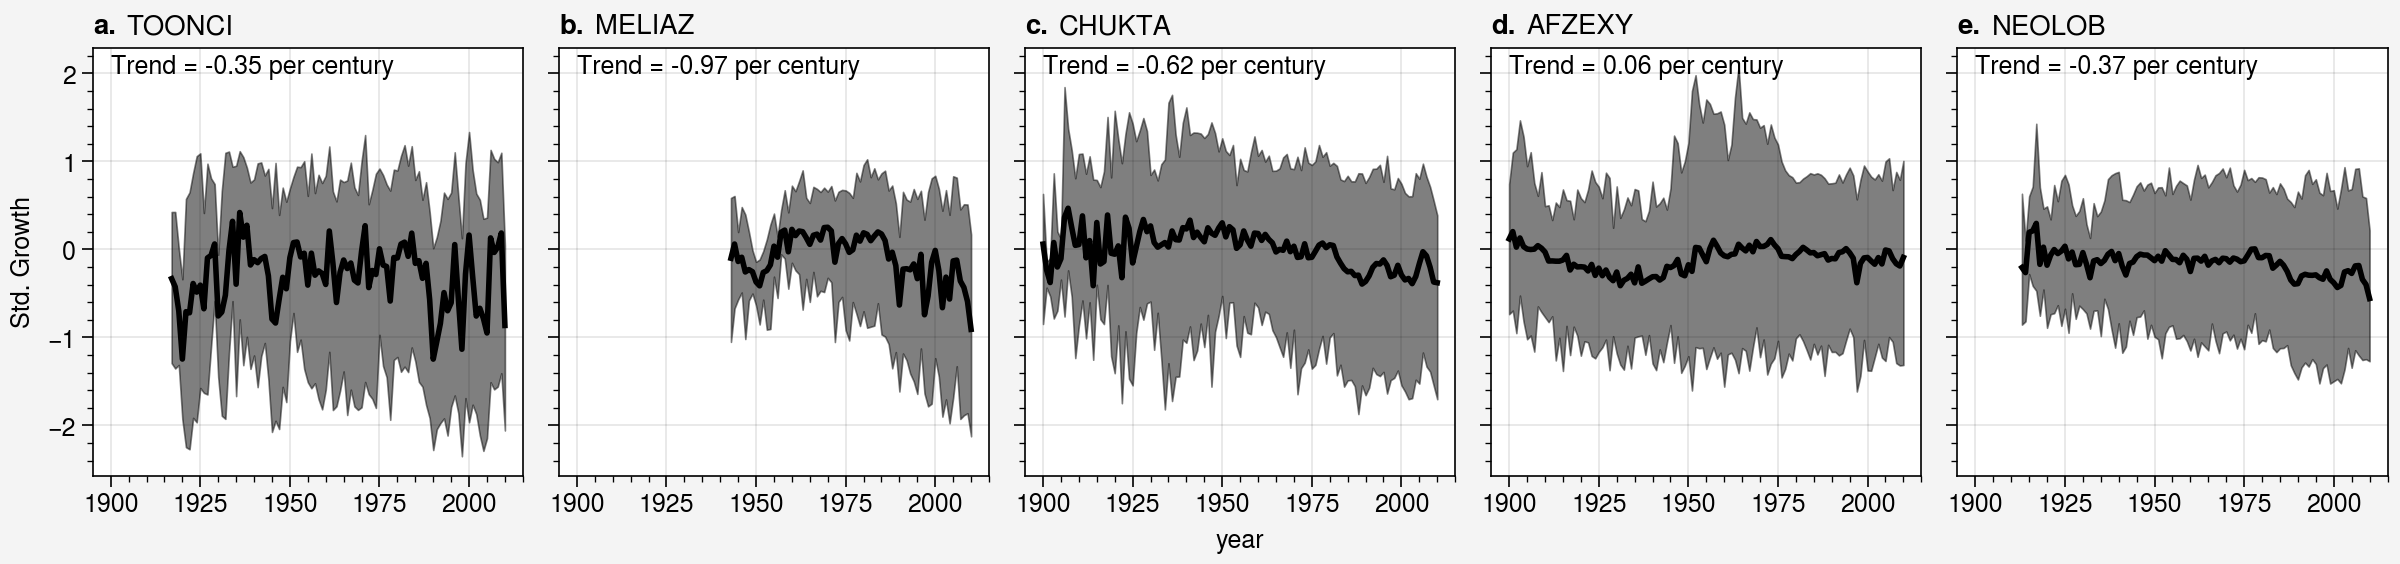

In [13]:
# loop over each sp to generate a GAM model
sp_list = ['TOONCI','MELIAZ','CHUKTA','AFZEXY','NEOLOB']
dbh_max = []
popts = []
popts_ma = []

yeara = 1900
yearz = 2010

dbh_str = "dbh >= 5"

fig, axes = pplt.subplots(ncols=5,nrows=1,figwidth=12)
for i, ax in enumerate(axes):
    # loop over species
    sp = sp_list[i]
    sp_mask = df_tr_obs.Species == sp
    bai_mask = df_tr_obs.BAI > 0.
    df_sp = df_tr_obs[sp_mask & bai_mask]
    print(df_sp.shape)

    # standardize the growth
    df_sp_rcs, popt, popt_ma = std_tr(df_sp)

    # generate mean and 95 percentile for each year
    X = np.arange(yeara,yearz+1)
    Y_mean = np.zeros_like(X) * np.nan
    Y_up   = np.zeros_like(X) * np.nan
    Y_low  = np.zeros_like(X) * np.nan

    for ix, year in enumerate(X):
        df_sub = df_sp_rcs.query(f"Year == {year} & {dbh_str}")
        if df_sub.shape[0] > 3:
            Y_mean[ix] = np.nanmean(df_sub.BAI_rcs.values)
            Y_up[ix] = np.nanpercentile(df_sub.BAI_rcs.values,95.)
            Y_low[ix] = np.nanpercentile(df_sub.BAI_rcs.values,5.)
    
    ax.plot(X,Y_mean,c='k',lw=2.)
    ax.area(X,Y_low,Y_up,c='k',alpha=0.5)

    # regression

    reg_x = df_sp_rcs.query(f"Year >= {yeara} & {dbh_str}").Year.values
    reg_y = df_sp_rcs.query(f"Year >= {yeara} & {dbh_str}").BAI_rcs.values
    reg_mask = np.isfinite(reg_x) & np.isfinite(reg_y)
    reg_res = sm.OLS(reg_y,sm.add_constant(reg_x)).fit()

    print(reg_res.params)
    print(reg_res.pvalues)
    
    ax.format(title=sp)

    ax.text(yeara,2,
            f'Trend = {reg_res.params[1]*100:4.2f} per century')




axes.format(xlim=(yeara-5,yearz+5),xlabel='year', ylabel='Std. Growth',abc='a.',titleloc='l')

(6549, 11)
[ 2.82526356e+00 -1.57614263e-03]
[0.00822314 0.00343861]
(22311, 11)
[ 1.08334575e+01 -5.51033118e-03]
[1.83736863e-150 1.17928152e-151]


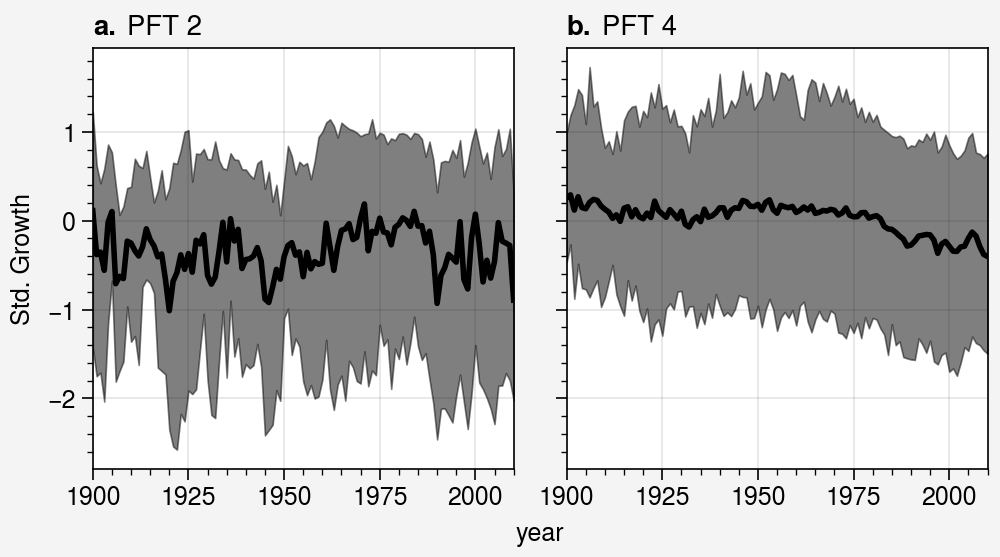

In [14]:
# loop over each sp to generate a GAM model
pft_list = [2,4]
dbh_max = []
popts = []
popts_ma = []

yeara = 1900
yearz = 2010

dbh_str = "dbh >= 5"

fig, axes = pplt.subplots(ncols=2,nrows=1,figwidth=5)
for i, ax in enumerate(axes):
    # loop over species
    PFT = pft_list[i]
    sp_mask = df_tr_obs.PFT == PFT
    bai_mask = df_tr_obs.BAI > 0.
    df_sp = df_tr_obs[sp_mask & bai_mask]
    print(df_sp.shape)

    # standardize the growth
    df_sp_rcs, popt, popt_ma = std_tr(df_sp)

    # generate mean and 95 percentile for each year
    X = np.arange(yeara,yearz+1)
    Y_mean = np.zeros_like(X) * np.nan
    Y_up   = np.zeros_like(X) * np.nan
    Y_low  = np.zeros_like(X) * np.nan

    for ix, year in enumerate(X):
        df_sub = df_sp_rcs.query(f"Year == {year} & {dbh_str}")
        if df_sub.shape[0] > 3:
            Y_mean[ix] = np.nanmean(df_sub.BAI_rcs.values)
            Y_up[ix] = np.nanpercentile(df_sub.BAI_rcs.values,95.)
            Y_low[ix] = np.nanpercentile(df_sub.BAI_rcs.values,5.)
    
    ax.plot(X,Y_mean,c='k',lw=2.)
    ax.area(X,Y_low,Y_up,c='k',alpha=0.5)

    # regression

    reg_x = df_sp_rcs.query(f"Year >= {yeara} & {dbh_str}").Year.values
    reg_y = df_sp_rcs.query(f"Year >= {yeara} & {dbh_str}").BAI_rcs.values
    reg_mask = np.isfinite(reg_x) & np.isfinite(reg_y)
    reg_res = sm.OLS(reg_y,sm.add_constant(reg_x)).fit()

    print(reg_res.params)
    print(reg_res.pvalues)
    
    ax.format(title=f'PFT {PFT}')


axes.format(xlabel='year', ylabel='Std. Growth',abc='a.',titleloc='l')

2.2 dC13 analysis



In [15]:
# read CO2 data
df_C13 = pd.read_excel(f'{data_dir}ngeo2313-s2.xlsx')

df_C13 = df_C13.query('Area == "HKK"')


C13_pft_dict = {
    'Afzelia_xylocarpa' : 4,
    'Melia_azedarach'   : 2,
    "Chukrasia_tabularis" : 4,
    "Toona_ciliata" : 2,
}

C13_sp_dict = {
    'Afzelia_xylocarpa' : 'AFZEXY',
    'Melia_azedarach'   : 'MELIAZ',
    "Chukrasia_tabularis" : 'CHUKTA',
    "Toona_ciliata" : 'TOONCI',
}

df_C13 = df_C13.assign(PFT=[C13_pft_dict[row.Species] for i, row in df_C13.iterrows()])
df_C13['Species'] = [C13_sp_dict[row.Species] for i, row in df_C13.iterrows()]
df_C13 = df_C13.rename(columns={ 'Year_sample' : 'Year',
                        'Tree_code' : 'Tree',
                        'dbh_sample' : 'dbh'})



(97, 29)
[-1.09731831e+03  6.76002688e-01 -1.23030391e+00]
[4.61368184e-11 2.84259896e-14 1.73087899e-09]
(148, 29)
[-1.24324057e+03  7.39540186e-01 -3.64906230e-01]
[2.55034755e-14 4.11938166e-18 2.94493170e-03]
(142, 29)
[-1.02902692e+03  6.37102896e-01 -9.58823386e-01]
[4.06596177e-25 5.82604706e-32 3.40282228e-16]
(164, 29)
[-6.83199897e+02  4.53553433e-01 -9.89407103e-01]
[9.81221286e-08 1.95246588e-11 3.31004774e-10]


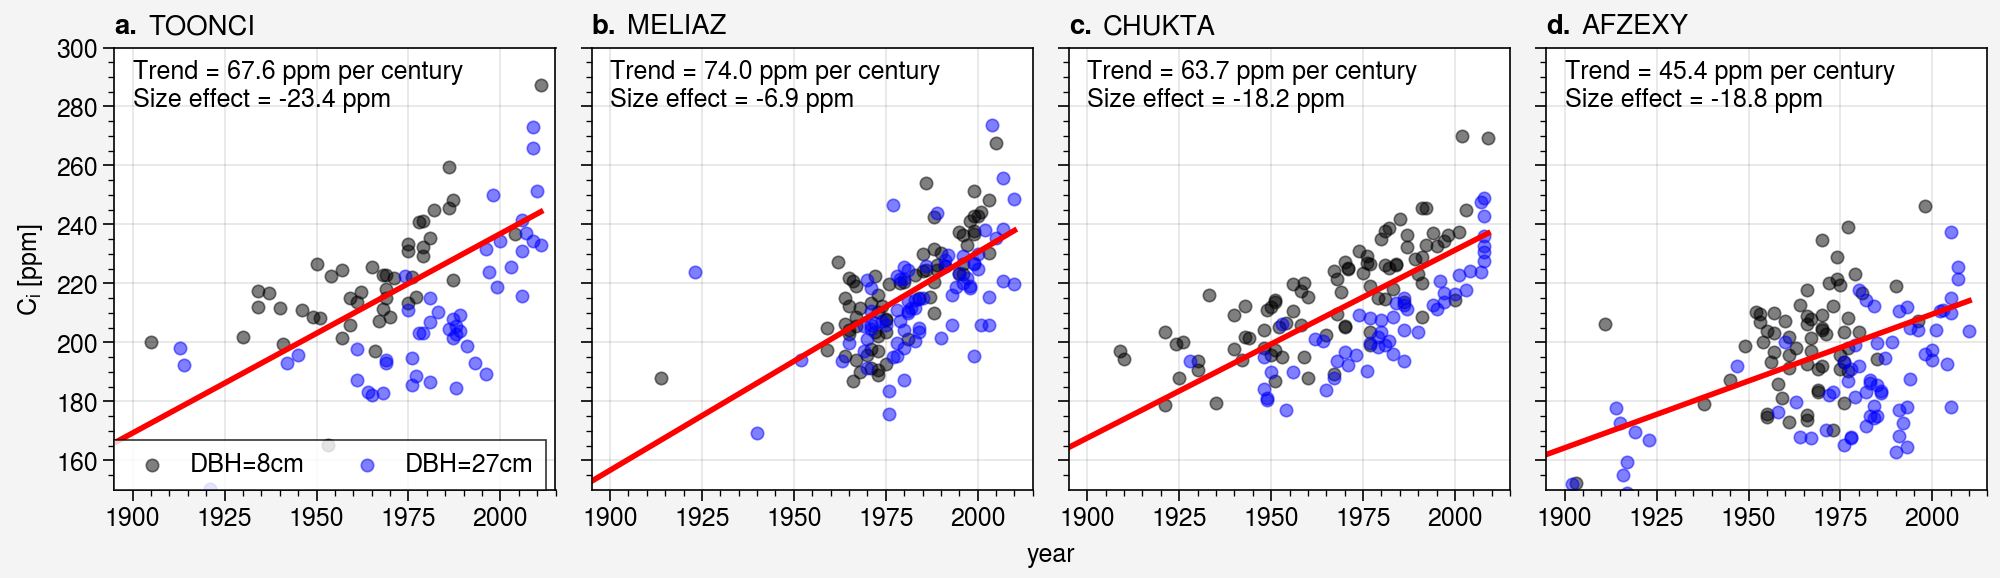

In [145]:
# loop over each sp to generate a GAM model
sp_list = ['TOONCI','MELIAZ','CHUKTA','AFZEXY'] #,'NEOLOB'] # no NEOLOB for C13
dbh_max = []
popts = []
popts_ma = []

yeara = 1900
yearz = 2010

dbh_str = "dbh >= 0"

fig, axes = pplt.subplots(ncols=4,nrows=1,figwidth=10)
for i, ax in enumerate(axes):
    # loop over species
    sp = sp_list[i]
    sp_mask = df_C13.Species == sp
    df_sp = df_C13[sp_mask]
    print(df_sp.shape)
    df_small = df_sp.query(f'dbh < 10 & Year >= {yeara}')
    df_large = df_sp.query(f'dbh > 10 & Year >= {yeara}')



    # regression

    reg_x = df_sp.query(f"Year >= {yeara} & {dbh_str}")[['Year','dbh']].values
    reg_y = df_sp.query(f"Year >= {yeara} & {dbh_str}").Ci.values
    reg_mask =  np.isfinite(reg_y)
    reg_res = sm.OLS(reg_y,sm.add_constant(reg_x)).fit()

    print(reg_res.params)
    print(reg_res.pvalues)

    ax.scatter(df_small.Year,df_small.Ci,c='k',s=20,alpha=0.5,label='DBH=8cm')
    ax.scatter(df_large.Year,df_large.Ci,c='b',s=20,alpha=0.5,label='DBH=27cm')

    line_x = np.array([np.amin(reg_x), np.amax(reg_x)])
    line_y = reg_res.params[0] + reg_res.params[1] * line_x + reg_res.params[2] * (2 + 27) / 2
    ax.plot(line_x,line_y,c='r',lw=2)

    ax.format(title=sp)
    
    ax.text(yeara,280,
            f'Trend = {reg_res.params[1]*100:4.1f} ppm per century' +
            f'\nSize effect = {reg_res.params[2] * (27-8):4.1f} ppm')

    if i == 0:
        ax.legend(loc='ll')

    # rax = ax.panel('r',space=0.)
    # data = np.reshape([df_small.Ci.values, df_large.Ci.values])
    # rax.scatter(data,color='k',marker='x',markersize=50,barcolor='gray',
    #             medians=True,barstd=True,barrange=(-1,1),capsize=2)
    # rax.format(xtickrange=(0,1),xticklabels=['8cm','27cm'])


axes.format(xlim=(yeara-5,yearz+5),ylim=(150,300),
            xlabel='year', ylabel='$C_i$ [ppm]',abc='a.',titleloc='l')
fig.savefig('./Figures/Fig_S_Ci_size.png',dpi=300)


3. Key results figures

3.0 Read simulation/observation data

In [17]:
# read polygon level output
# save them as sim_ds_py
import xarray as xr
import datetime

# only show inCO2
sim_setups = [
    '2PFT_SLZ2_VM2_inCO2',    
    '2PFT_SLZ2_VM2_exCO2',
]

sim_dir = './Sim/'
sim_data_py = [xr.open_dataset(f'{sim_dir}HKK_{sim_setup}/HKK_{sim_setup}_py.nc') for sim_setup in sim_setups]

# convert the time coord to datetime
for sim_ds_py in sim_data_py:
    sim_ds_py.coords['time'] = [
        datetime.datetime.fromisoformat(datestr+'-01') 
        for datestr in sim_ds_py.coords['time'].values]


In [52]:
# main figure for model benchmark
# use 10-year average Ci and Growth

##########################
# Data Preparation
##########################
# observed basal area from HKK standbook, unit is m2/ha
ba_obs_mu = np.array([30.39,28.64,20.33,5.57])
ba_obs_sd = np.array([5.70,5.70,5.43,4.46])
nplant_obs_mu = np.array([1609,438,83,5.6]) # #/ha
size_label = ['$\geq$1cm','$\geq$10cm','$\geq$30cm','$\geq$100cm']

df_gpp = pd.read_excel(f'{data_dir}Thailand_Jung_GPP_2001_2015.xlsx',header=None)
df_gpp = df_gpp.rename(columns={0 : 'Time', 1 : 'GPP'})
df_gpp['Year'] = df_gpp.Time // 100
df_gpp['Month'] = df_gpp.Time % 100
# get average from 2001 to 2010
gpp_avg = df_gpp.query('Year < 2011').GPP.mean() * 12 / 1000 # convert to kgC/m2/yr
gpp_wet = df_gpp.query('Year < 2011 & (Month > 4 & Month < 11)').GPP.mean() * 12 / 1000 # convert to kgC/m2/yr
gpp_dry = df_gpp.query('Year < 2011 & ~(Month > 4 & Month < 11)').GPP.mean() * 12 / 1000 # convert to kgC/m2/yr

# SLZ2 use square, SLZ4 use triangle
# 1500/1800  use colors
# 


color_dict = {
    '2PFT_SLZ2_VM2_inCO2' : 'xkcd:orange',
    '2PFT_SLZ2_VM2_exCO2' : 'xkcd:forest green',
}

label_dict = {
    '2PFT_SLZ2_VM2_inCO2' : 'CO2-inc',
    '2PFT_SLZ2_VM2_exCO2' : 'CO2-const',
}

plot_setups = ['2PFT_SLZ2_VM2_inCO2',
               '2PFT_SLZ2_VM2_exCO2']


# for size-dependence growth

pft_dict = {
    'TOONCI' : 2,
    'MELIAZ' : 2,
    'CHUKTA' : 4,
    'AFZEXY' : 4,
    'NEOLOB' : 4,
}

sp_list = list(pft_dict.keys())
PFT_labels = ['Early','Late']
pft_list = [2,4]

In [53]:
print(gpp_avg,gpp_wet,gpp_dry)

2.3940413783788683 2.6091006503105163 2.17898210644722


In [54]:
sim_ds = sim_data_py[0]
date1 = datetime.datetime.fromisoformat('2001-01-01')
date2 = datetime.datetime.fromisoformat('2010-12-31')



In [56]:
df_mlk = pd.read_csv('./Data/MLK_GPPdata.csv')
month_doy = np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31])
month_gpp = []
for i in range(12):
    month_gpp.append(df_mlk.query(f'DOY >= {month_doy[i]} & DOY < {month_doy[i+1]}').GPP.mean() * 12 * 1e-6 * 1e-3 * 86400)
    # kgC/m2/d

In [62]:
df_mlk_month = pd.DataFrame({'Month' : np.arange(1,12+1),
                             'GPP'   : month_gpp})

scaler = 3.23 / 365 - df_mlk_month.GPP.mean()
df_mlk_month.GPP = df_mlk_month.GPP.values + scaler

df_gpp_season = df_mlk_month.copy()
df_gpp_season.rename(columns={'GPP':'MKL'},inplace=True)
df_gpp_season.MKL *= 1000 # gC/m2/d

df_gpp_season['FLUXCOM'] = df_gpp.dropna().groupby('Month').mean().GPP.values / 30 # convert to gC/m2/d

df_gpp_year = df_gpp.groupby('Year').mean().reset_index()[['Year','GPP']].query('Year <= 2010')


df_gpp_year.GPP /= 30

In [63]:
date1 = datetime.datetime.fromisoformat('2001-01-01')
date2 = datetime.datetime.fromisoformat('2010-12-31')


In [64]:
sim_ds = sim_data_py[0]
sim_gpp = ( sim_ds['QMEAN_GPP_PY'].sel(time=slice(date1,date2)).values
                                  .mean(axis=0).reshape((-1,12))
                                  .mean(axis=0)
          ) / 365 * 1000 # gC/m2/d
df_gpp_season['CO2inc'] = sim_gpp

sim_gpp = ( sim_ds['QMEAN_GPP_PY'].sel(time=slice(date1,date2)).values
                                  .mean(axis=0).reshape((-1,12))
                                  .mean(axis=1)
          ) / 365 * 1000 # gC/m2/d
df_gpp_year['CO2inc'] = sim_gpp

In [65]:
sim_ds = sim_data_py[1]
sim_gpp = ( sim_ds['QMEAN_GPP_PY'].sel(time=slice(date1,date2)).values
                                  .mean(axis=0).reshape((-1,12))
                                  .mean(axis=0)
          ) / 365 * 1000 # gC/m2/d
df_gpp_season['CO2fix'] = sim_gpp

sim_gpp = ( sim_ds['QMEAN_GPP_PY'].sel(time=slice(date1,date2)).values
                                  .mean(axis=0).reshape((-1,12))
                                  .mean(axis=1)
          ) / 365 * 1000 # gC/m2/d
df_gpp_year['CO2fix'] = sim_gpp

In [66]:
np.std(np.log(df_gpp_year.GPP)) - np.std(np.log(df_gpp_year.CO2inc))

-0.0720283411604544

In [67]:
df_gpp_year['PDRY'] = PRCP_dry[-11:-1]

3.1 Model Benchmark

[29.9731517  24.56293146  5.95130155]
[24.81164246 20.16398717  2.93659572]
[277.39160845  87.44957144   6.67219239]
[262.01545349  84.43486951   3.41855543]


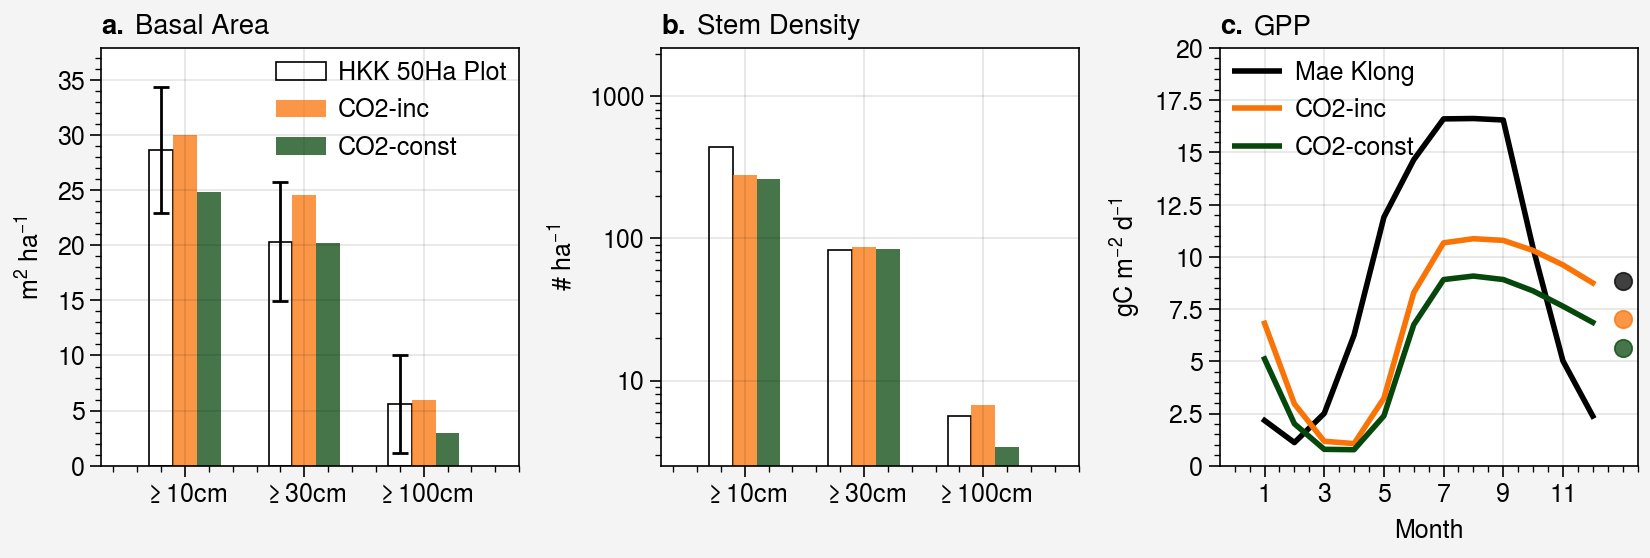

In [70]:
fig, axes = pplt.subplots(ncols=3,nrows=1,figwidth=2.75*3,sharey=False)
hs = []

# basal area
ax = axes[0]
x_pos = np.arange(len(ba_obs_mu))
width = 0.2
h = ax.bar(x_pos,ba_obs_mu,bardata=np.vstack([ba_obs_mu - ba_obs_sd, ba_obs_mu + ba_obs_sd])
       ,width=width,facecolor='none',edgecolor='k',label='HKK 50Ha Plot') 
hs.append(h)
# add model outputs

for i, sim_setup in enumerate(plot_setups):
           
    sim_ds = sim_data_py[i]
    
    linecolor = color_dict[sim_setup]
    facecolor = linecolor
        
    # the HKK stand book said the plot survey was conducted in 1990-1991 but never clear whether the
    # census was done in the same period of time.
    
    date1 = datetime.datetime.fromisoformat('1990-01-01')
    date2 = datetime.datetime.fromisoformat('1991-12-31')
    sim_ba = sim_ds['BASAL_AREA_PY'].sel(time=slice(date1,date2)).mean(dim=['time'])
    
    sim_ba_10 = sim_ba.sel(size=slice(1,None)).sum()
    sim_ba_30 = sim_ba.sel(size=slice(3,None)).sum()
    sim_ba_100 = sim_ba.sel(size=slice(10,None)).sum()
    
    x_pos = np.arange(1,len(ba_obs_mu)) + width * (i+1)
    
    y_val = np.array([sim_ba_10.values,sim_ba_30.values,sim_ba_100.values])
    print(y_val)
    ax.bar(x_pos,y_val,width=width,facecolor=color_dict[sim_setup],label=label_dict[sim_setup],alpha=0.75)
    

ax.format(title='Basal Area',ylabel='$m^2$ $ha^{-1}$',
          xlocator=x_pos-width,xticklabels=size_label[1::],
          xlim=(0.5,4.0)) 
ax.legend(loc='ur',frameon=False,ncols=1)

# stem density
ax = axes[1]
x_pos = np.arange(len(nplant_obs_mu))
width = 0.2
ax.bar(x_pos,nplant_obs_mu
       ,width=width,facecolor='none',edgecolor='k',label='HKK 50ha Plot')
#ax.bar(x_pos,np.zeros_like(nplant_obs_mu) * np.nan,width=width,facecolor='none',edgecolor='k'
#            ,hatch='//',label='MPI-MTE GPP')


# add model outputs
for i, sim_setup in enumerate(plot_setups):
            
    sim_ds = sim_data_py[i]
    
    linecolor = color_dict[sim_setup]
    facecolor = linecolor
        
   
    # the HKK stand book said the plot survey was conducted in 1990-1991 but never clear whether the
    # census was done in the same period of time.
    
    date1 = datetime.datetime.fromisoformat('1990-01-01')
    date2 = datetime.datetime.fromisoformat('1991-12-31')
    sim_nplant = sim_ds['NPLANT_PY'].sel(time=slice(date1,date2)).mean(dim=['time'])
    
    sim_nplant_10 = sim_nplant.sel(size=slice(1,None)).sum() * 1e4
    sim_nplant_30 = sim_nplant.sel(size=slice(3,None)).sum() * 1e4
    sim_nplant_100 = sim_nplant.sel(size=slice(10,None)).sum() * 1e4
    
    x_pos = np.arange(1,len(nplant_obs_mu)) + width * (i+1)
    
    
    y_val = np.array([sim_nplant_10.values,sim_nplant_30.values,sim_nplant_100.values])
    print(y_val)
    
    ax.bar(x_pos,y_val,width=width,facecolor=color_dict[sim_setup],label=label_dict[sim_setup],alpha=0.75)

#    ax.scatter(x_pos,y_val,s=50,facecolor=facecolor,edgecolors=linecolor,
#               marker = marker,alpha=0.5,label=sim_setup)
    
ax.format(title='Stem Density',ylabel='# $ha^{-1}$',
          xlocator=x_pos-width,xticklabels=size_label[1::],
          xlim=(0.5,4.0),yscale='log')

# productivity
ax = axes[2]
#ax.plot(df_gpp_season.Month,df_gpp_season.FLUXCOM,c='k',lw=2,label='FLUXCOM')
ax.plot(df_gpp_season.Month,df_gpp_season.MKL,c='k',lw=2,label='Mae Klong')
ax.plot(df_gpp_season.Month,df_gpp_season.CO2inc,c='xkcd:orange',lw=2,label='CO2-inc')
ax.plot(df_gpp_season.Month,df_gpp_season.CO2fix,c='xkcd:forest green',lw=2,label='CO2-const')

# plot annual mean
#ax.scatter(13,df_gpp_season.FLUXCOM.mean(),s=40,c='k',alpha=0.75)
ax.scatter(13,df_gpp_season.MKL.mean(),s=40,c='k',alpha=0.75)
ax.scatter(13,df_gpp_season.CO2inc.mean(),s=40,c='xkcd:orange',alpha=0.75)
ax.scatter(13,df_gpp_season.CO2fix.mean(),s=40,c='xkcd:forest green',alpha=0.75)

ax.format(title='GPP',ylabel='$gC$ $m^{-2}$ $d^{-1}$', 
          xlabel='Month',ylim=(0,20),xlim=(-0.5,13.5),xticks=[1,3,5,7,9,11])
ax.legend(loc='ul',ncol=1,frameon=False)
            
axes.format(abc='a.',titleloc='l')
#fig.legend(hs,loc='b',ncol=4)
fig.savefig('./Figures/Fig2.png',dpi=300)
fig.savefig('./Figures/Fig2.tiff',dpi=300)

2.38704021019057
2.049926439639883
0.8876790454492859
0.7340800347687075
3.155710471707962
2.958571838156448


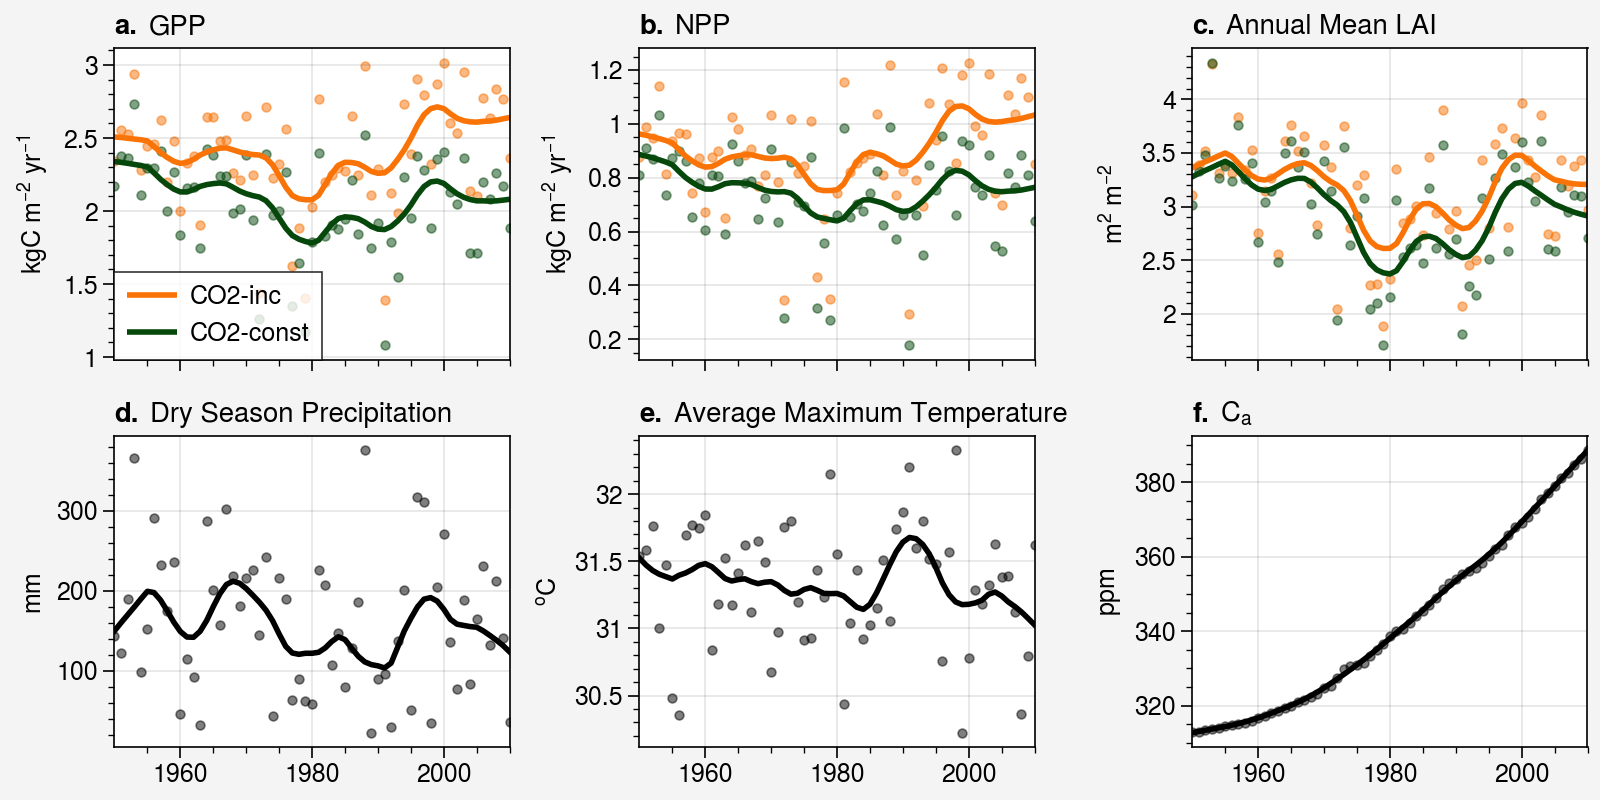

In [146]:
# figure on ecosystem-level trend
# GPP, NPP:GPP, woody NPP : GPP
# PRCP, TAVG, aCO2

import statsmodels.api as sm
lowess = sm.nonparametric.lowess


labels = ['OBS','CO2-inc','CO2-const']
colors = ['k','xkcd:orange','xkcd:forest green']

date1 = datetime.datetime.fromisoformat('1950-01-01')
date2 = datetime.datetime.fromisoformat('2010-12-31')

hs = []

fig, axes = pplt.subplots(ncols=3,nrows=2,sharex=True,sharey=False,figwidth=8.,figheight=4.)

for i, ax in enumerate(axes[0:3]):
    
    for j in [1,2]:
        sim_ds = sim_data_py[j-1]
        if i == 0:
            Y = sim_ds['MMEAN_GPP_PY'].sel(time=slice(date1,date2))
            plot_y = np.reshape(Y.values,(-1,12)).mean(axis=1)
            unit = r'$kgC$ $m^{-2}$ $yr^{-1}$'
            title = 'GPP'
        elif i == 1:
            Y = sim_ds['MMEAN_NPP_PY'].sel(time=slice(date1,date2))
            plot_y = np.reshape(Y.values,(-1,12)).mean(axis=1)
            unit = r'$kgC$ $m^{-2}$ $yr^{-1}$'
            title = 'NPP'
        elif i == 2:
            Y = sim_ds['MMEAN_LAI_PY'].sel(time=slice(date1,date2)).sum(dim=['size','pft'])
            plot_y = np.reshape(Y.values,(-1,12)).mean(axis=1)
            unit = r'$m^2$ $m^{-2}$'
            title = 'Annual Mean LAI'
        
     
        plot_x = np.arange(1950,2010+1)

        # scatter plot
        ax.scatter(plot_x,plot_y,s=10,c=colors[j],alpha=0.5)
        print(np.nanmean(plot_y))
        
        # spline fitting
        z = lowess(plot_y, plot_x, frac= 1./5)
        hp = ax.plot(z[:,0],z[:,1],c=colors[j],label=labels[j],lw=2)
        if i == 0:
            hs.append(hp)

        ax.format(title=title,ylabel=unit)
    
    if i == 0:
        ax.legend(hs,loc='ll',ncols=1)

for i, ax in enumerate(axes[3::]):
    plot_x = np.arange(1950,2010+1)
    y_mask = (met_year >= plot_x[0]) & (met_year <= plot_x[-1])

    if i == 0:
        plot_y = PRCP_dry[y_mask]
        unit = r'mm'
        title='Dry Season Precipitation'
    elif i == 1:
        plot_y = TMAX[y_mask]
        unit = r'$^oC$'
        title='Average Maximum Temperature'
    elif i == 2:
        plot_y = aCO2[y_mask]
        unit = r'$ppm$'
        title='$C_a$'
        
    # scatter plot
    ax.scatter(plot_x,plot_y,s=10,c='k',alpha=0.5)

    # spline fitting
    z = lowess(plot_y, plot_x, frac= 1./5)
    hp = ax.plot(z[:,0],z[:,1],c='k',lw=2)

    ax.format(title=title,ylabel=unit)

        
axes.format(abc='a.',titleloc='l')
fig.savefig('./Figures/Fig_S_ecosystem.png',dpi=300)
fig.savefig('./Figures/Fig_S_ecosystem.tiff',dpi=300)

    
        
    # the HKK stand book said the plot survey was conducted in 1990-1991 but never clear whether the
    # census was done in the same period of time.
    
#    sim_ba = sim_ds['BASAL_AREA_PY'].sel(time=slice(date1,date2)).mean(dim=['time'])
 



-12.258030583712738
-15.288765275746472


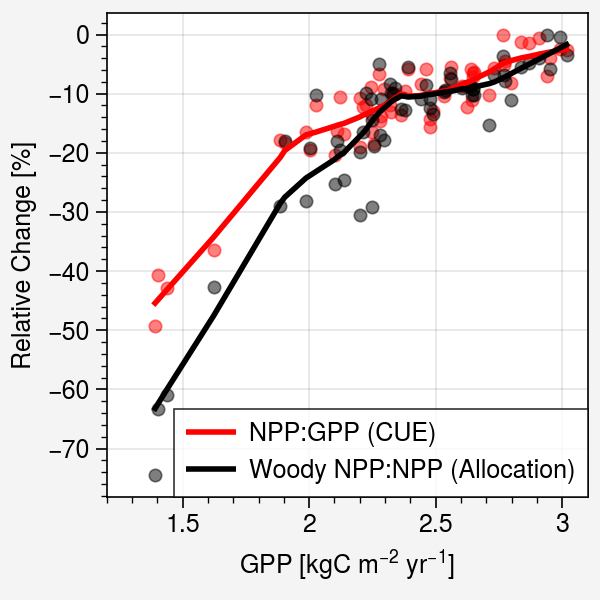

In [639]:
# figure on ecosystem-level trend
import statsmodels.api as sm
lowess = sm.nonparametric.lowess


labels = ['OBS','ED2-inCO2','ED2-exCO2']
colors = ['k','xkcd:orange','xkcd:forest green']

date1 = datetime.datetime.fromisoformat('1950-01-01')
date2 = datetime.datetime.fromisoformat('2010-12-31')

hs = []

fig, ax = pplt.subplots(ncols=1,nrows=1,sharex=True,sharey=False,
                          figwidth=3.,figheight=3.)

sim_ds = sim_data_py[0]
years = np.arange(1950,2010+1)
y_mask = (met_year >= years[0]) & (met_year <= years[-1])
plot_pdry = PRCP_dry[y_mask]

Y = sim_ds['MMEAN_GPP_PY'].sel(time=slice(date1,date2))
plot_x = np.reshape(Y.values,(-1,12)).mean(axis=1)

y_array = []
for i in range(2):
    if i == 0:
        Y1 = sim_ds['MMEAN_NPP_PY'].sel(time=slice(date1,date2))
        Y2 = sim_ds['MMEAN_GPP_PY'].sel(time=slice(date1,date2))
        plot_y = np.reshape(Y1.values,(-1,12)).mean(axis=1) / np.reshape(Y2.values,(-1,12)).mean(axis=1)
        unit = r'%'
        title = 'NPP : GPP (CUE)'

    elif i == 1:
        Y1 = (
                sim_ds['MMEAN_NPPWOOD_PY'].sel(time=slice(date1,date2)) + 
                sim_ds['MMEAN_NPPSAPWOOD_PY'].sel(time=slice(date1,date2)) + 
                sim_ds['MMEAN_NPPCROOT_PY'].sel(time=slice(date1,date2)) 
            )

        Y2 = sim_ds['MMEAN_NPP_PY'].sel(time=slice(date1,date2))
        plot_y = np.reshape(Y1.values,(-1,12)).mean(axis=1) / np.reshape(Y2.values,(-1,12)).mean(axis=1) 

        unit = r'%'
        title = 'woody NPP : NPP (allocation)'


    elif i == 2:
        Y1 = (
                sim_ds['MMEAN_NPPWOOD_PY'].sel(time=slice(date1,date2)) + 
                sim_ds['MMEAN_NPPSAPWOOD_PY'].sel(time=slice(date1,date2)) + 
                sim_ds['MMEAN_NPPCROOT_PY'].sel(time=slice(date1,date2)) 
            )

        Y2 = sim_ds['MMEAN_GPP_PY'].sel(time=slice(date1,date2))
        plot_y = np.reshape(Y1.values,(-1,12)).mean(axis=1) / np.reshape(Y2.values,(-1,12)).mean(axis=1)

        unit = r'%'
        title = 'woody NPP : GPP (WBPE)'


    # scatter plot
    plot_y = (plot_y / np.amax(plot_y) - 1) * 100
    y_array.append(plot_y)

colors = ['r','k','b']
labels = ['NPP:GPP (CUE)','Woody NPP:NPP (Allocation)']
hs = []
for i, plot_y in enumerate(y_array):
    
    ax.scatter(plot_x,plot_y,s=20,colors=colors[i],alpha=0.5)
    print(np.nanmean(plot_y))

    # spline fitting
    
    z = lowess(plot_y, plot_x, frac= 1./3)
    hp = ax.plot(z[:,0],z[:,1],colors=colors[i],lw=2,label=labels[i])
    
    hs.append(hp)
    
    
ax.legend(hs,loc='lr',ncols=1)
ax.format(xlim=(1.2,3.1),xlabel=r'GPP [$kgC$ $m^{-2}$ $yr^{-1}$]',
          ylabel='Relative Change [%]')
        
fig.savefig('./Figures/Fig7.png',dpi=300)
fig.savefig('./Figures/Fig7.tiff',dpi=300)

    
        
    # the HKK stand book said the plot survey was conducted in 1990-1991 but never clear whether the
    # census was done in the same period of time.
    
#    sim_ba = sim_ds['BASAL_AREA_PY'].sel(time=slice(date1,date2)).mean(dim=['time'])
 



In [536]:
date1 = datetime.datetime.fromisoformat('2000-01-01')
date2 = datetime.datetime.fromisoformat('2010-12-31')
sim_data_py[0]['AGB_PY'].sel(time=slice(date1,date2),size=slice(0,11)).sum(dim=['size','pft']).mean(dim=['time'])


<xarray.DataArray 'AGB_PY' ()>
array(18.28638432)

3.2 Temporal trend and size dependence

In [84]:
# first need to sample simulated tree rings
sim_tr_setups = ['2PFT_SLZ2_VM2_inCO2','2PFT_SLZ2_VM2_exCO2',]
yeara, yearz = 1600, 2010
#sim_setups = ['drd_inCO2','drd_exCO2']
#yeara, yearz = 1850, 2010


data_dir = './Sim'
df_tr_sims = [pd.read_csv(f'{data_dir}HKK_{sim_setup}/HKK_{sim_setup}_tr_{yeara}_{yearz}.csv') for sim_setup in sim_tr_setups]


for df in df_tr_sims:
    # rename 3 as 4 for previous simulations
    mask = df.PFT == 3
    df.loc[mask,'PFT'] = 4
    df.rename(columns={'LINT_CO2':'Ci'},inplace=True)

In [85]:
# sample simulations and only get the survived tree rings...
def sample_sim_tr(df_tr_sim,df_tr_obs,dbh_bin=20.,dbh_low=5.,pft_list=[2,4],random_seed=42,margin=1):
    '''
        dbh_bin default to be 20cm
    '''
    
    yearz = df_tr_sim.growth_end_year.max()
    print(yearz)
    df_sim_all = df_tr_sim.rename(columns={'growth_end_year':'Year','DBH':'dbh','DDBH_DT' : 'dbhI',
                           'DBA_DT' : 'BAI','cohort_id' : 'Tree'})
    
    
    
    # add dbh_class
    df_sim_all = df_sim_all.assign(dbh_class=np.floor(df_sim_all.dbh.values // dbh_bin).astype(int))
    #big_mask = df_sim_all.dbh_class >= 150 // dbh_bin
    #df_sim_all.dbh_class[big_mask] = int(150 // dbh_bin)
    
    df_obs_all = df_tr_obs.assign(dbh_class=np.floor(df_tr_obs.dbh.values // dbh_bin).astype(int))
    #big_mask = df_obs_all.dbh_class >= 150 // dbh_bin
    #df_obs_all.dbh_class[big_mask] = int(150 // dbh_bin)
    

    df_sim_yearz = df_sim_all.query(f'(cohort_flag == 1) & (Year == {yearz}) & (dbh > {dbh_low})')
    df_obs_yearz = df_obs_all.query(f'(Year == {yearz}) & (dbh > {dbh_low})')
    
    

    
    obs_size_bins = df_obs_yearz.dbh_class.value_counts().sort_index()
    sim_size_bins = df_sim_yearz.dbh_class.value_counts().sort_index()

    # find the scaler of number of observations
    total_big_tree_obs = obs_size_bins[obs_size_bins.index >= 2].sum()
    total_big_tree_sim = sim_size_bins[sim_size_bins.index >= 2].sum()
    print(total_big_tree_obs,total_big_tree_sim)

    df_sim_yearz_sample = []
    for pft in pft_list:
        sub_obs_size_bins = df_obs_yearz.query(f'PFT == {pft}').dbh_class.value_counts().sort_index()
        sub_sim_size_bins = df_sim_yearz.query(f'PFT == {pft}').dbh_class.value_counts().sort_index()
    
        # find the scaler of number of observations
        sub_big_tree_obs = sub_obs_size_bins[sub_obs_size_bins.index >= 2].sum()
        sub_big_tree_sim = sub_sim_size_bins[sub_sim_size_bins.index >= 2].sum()
        print(sub_big_tree_obs,sub_big_tree_sim)
        #ref_freq_obs = obs_size_bins[obs_size_bins.idxmax()]
        #ref_freq_sim = sim_size_bins[obs_size_bins.idxmax()]
        
        # loop over size_bins
        for size_class, count in sub_sim_size_bins.iteritems():
            if size_class not in sub_obs_size_bins.index:
                # observation does not has this size class
                continue
                
            target_size = int(np.floor(
                total_big_tree_sim
                * sub_obs_size_bins[size_class] / total_big_tree_obs
            ))
            
            

            df_size = df_sim_yearz.query(f'(PFT == {pft}) & (dbh_class == {size_class})')

            if count == 0:
                # no cohorts,
                # do nothing
                pass
            if  count <= target_size:
                # simulated cohorts number smaller than target size
                # sample with replace
                # take all the trees
                # do nothing
                df_temp = df_size.copy()
                #df_temp = df_size.sample(target_size,weights='NPLANT',replace=True,random_state=random_seed)

                df_sim_yearz_sample.append(df_temp)

            elif target_size > 0:
                # sample cohorts without replace to get most variance

                # add sample id
                df_temp = df_size.sample(target_size,weights='NPLANT',replace=False,random_state=random_seed)

                df_sim_yearz_sample.append(df_temp)
                
            

    df_sim_yearz_final = pd.concat(df_sim_yearz_sample)   

 
    # generate final simulated tree ring from the ensemble sampling
    # loop over df_sim_final?
    df_sim_sample = []
    
    df_sim_yearz_final = df_sim_yearz_final.reset_index()
    for i, row in df_sim_yearz_final.iterrows():
        df_sub = df_sim_all.query(f'Tree == "{row.Tree}"')
        #df_sub = df_sub.assign(sample_id=[f'{row.Tree}_ens{int(row.ens)}_s{i}'] * df_sub.shape[0])
        #df_sub = df_sub.assign(ens=np.ones((df_sub.shape[0],))*(row.ens))
        df_sim_sample.append(df_sub)

    df_sim_sample = pd.concat(df_sim_sample)
    # add a species column
    df_sim_sample = df_sim_sample.assign(Species=df_sim_sample.PFT)

    # if dbhI > 2.5, it must be an error due to cohort fusion
    return df_sim_sample.query('BAI >= 0 & dbhI < 2.5').dropna()


In [86]:
df_tr_inCO2 = sample_sim_tr(df_tr_sims[0],df_tr_obs)
df_tr_exCO2 = sample_sim_tr(df_tr_sims[1],df_tr_obs)
df_all_inCO2 = df_tr_sims[0].rename(columns={'growth_end_year':'Year','DBH':'dbh','DDBH_DT' : 'dbhI',
                           'DBA_DT' : 'BAI','cohort_id' : 'Tree'}).query(f'(dbh > 5)')
df_all_exCO2 = df_tr_sims[1].rename(columns={'growth_end_year':'Year','DBH':'dbh','DDBH_DT' : 'dbhI',
                           'DBA_DT' : 'BAI','cohort_id' : 'Tree'}).query(f'(dbh > 5)')
#df_tr_inCO2_deep = sample_sim_tr(df_tr_sims[2],df_tr_obs)
#df_tr_exCO2_deep = sample_sim_tr(df_tr_sims[3],df_tr_obs)


2010
219 72
99 45
120 27
2010
219 66
99 38
120 28


In [91]:
# generate corresponding Ci data
df_trees = df_tr_inCO2.groupby('Tree')

Ci_sim = []
for tree_id, df_tree in df_trees:
    for dbh_target in [8,27]:
        # find the tree ring closest to 8cm and 27cm
        if df_tree.dbh.max() < dbh_target or df_tree.dbh.min() > dbh_target:
            # do not have the specific ring
            # skip
            continue
        
        # other wise extract the year of the ring
        year_idx = np.argmin(np.absolute(df_tree.dbh.values - dbh_target))
        idx_array = np.arange(-2,2+1,1) + year_idx
        idx_array = idx_array[(idx_array >=0) & (idx_array < df_tree.shape[0])]
        data_ = df_tree[['Year','Tree','dbh','PFT']].iloc[year_idx,:].values.tolist()
        data_.append(np.nanmean(df_tree.Ci.values[idx_array]))
        Ci_sim.append(data_)

df_Ci_inCO2 = pd.DataFrame(Ci_sim,columns=['Year','Tree','dbh','PFT','Ci'])
        

df_trees = df_tr_exCO2.groupby('Tree')

Ci_sim = []
for tree_id, df_tree in df_trees:
    for dbh_target in [8,27]:
        # find the tree ring closest to 8cm and 27cm
        if df_tree.dbh.max() < dbh_target or df_tree.dbh.min() > dbh_target:
            # do not have the specific ring
            # skip
            continue
        
        # other wise extract the year of the ring
        year_idx = np.argmin(np.absolute(df_tree.dbh.values - dbh_target))
        idx_array = np.arange(-2,2+1,1) + year_idx
        idx_array = idx_array[(idx_array >=0) & (idx_array < df_tree.shape[0])]
        data_ = df_tree[['Year','Tree','dbh','PFT']].iloc[year_idx,:].values.tolist()
        data_.append(np.nanmean(df_tree.Ci.values[idx_array]))
        Ci_sim.append(data_)

df_Ci_exCO2 = pd.DataFrame(Ci_sim,columns=['Year','Tree','dbh','PFT','Ci'])

In [92]:
# add age since 1cm DBH
dfs_tr = [df_tr_obs,df_tr_inCO2,df_tr_exCO2]#,df_tr_inCO2_deep,df_tr_exCO2_deep]
for i, df_tr in enumerate(dfs_tr):
    # get tree list
    tree_list = df_tr.query('Year == 2010').Tree.value_counts().sort_index().index
    
    # loop over tree list and calculate tree age since 1cm
    df_tr['age_gt10'] = -1
    for j, tree in enumerate(tree_list):
        df_sub = df_tr.query(f'Tree == "{tree}" & dbh >= 10.')
        year_gt10 = df_sub.Year.min()
        df_tr.loc[df_tr.Tree == tree,'age_gt10'] = df_tr.Year[df_tr.Tree == tree].values - year_gt10
    
    dfs_tr[i] = df_tr


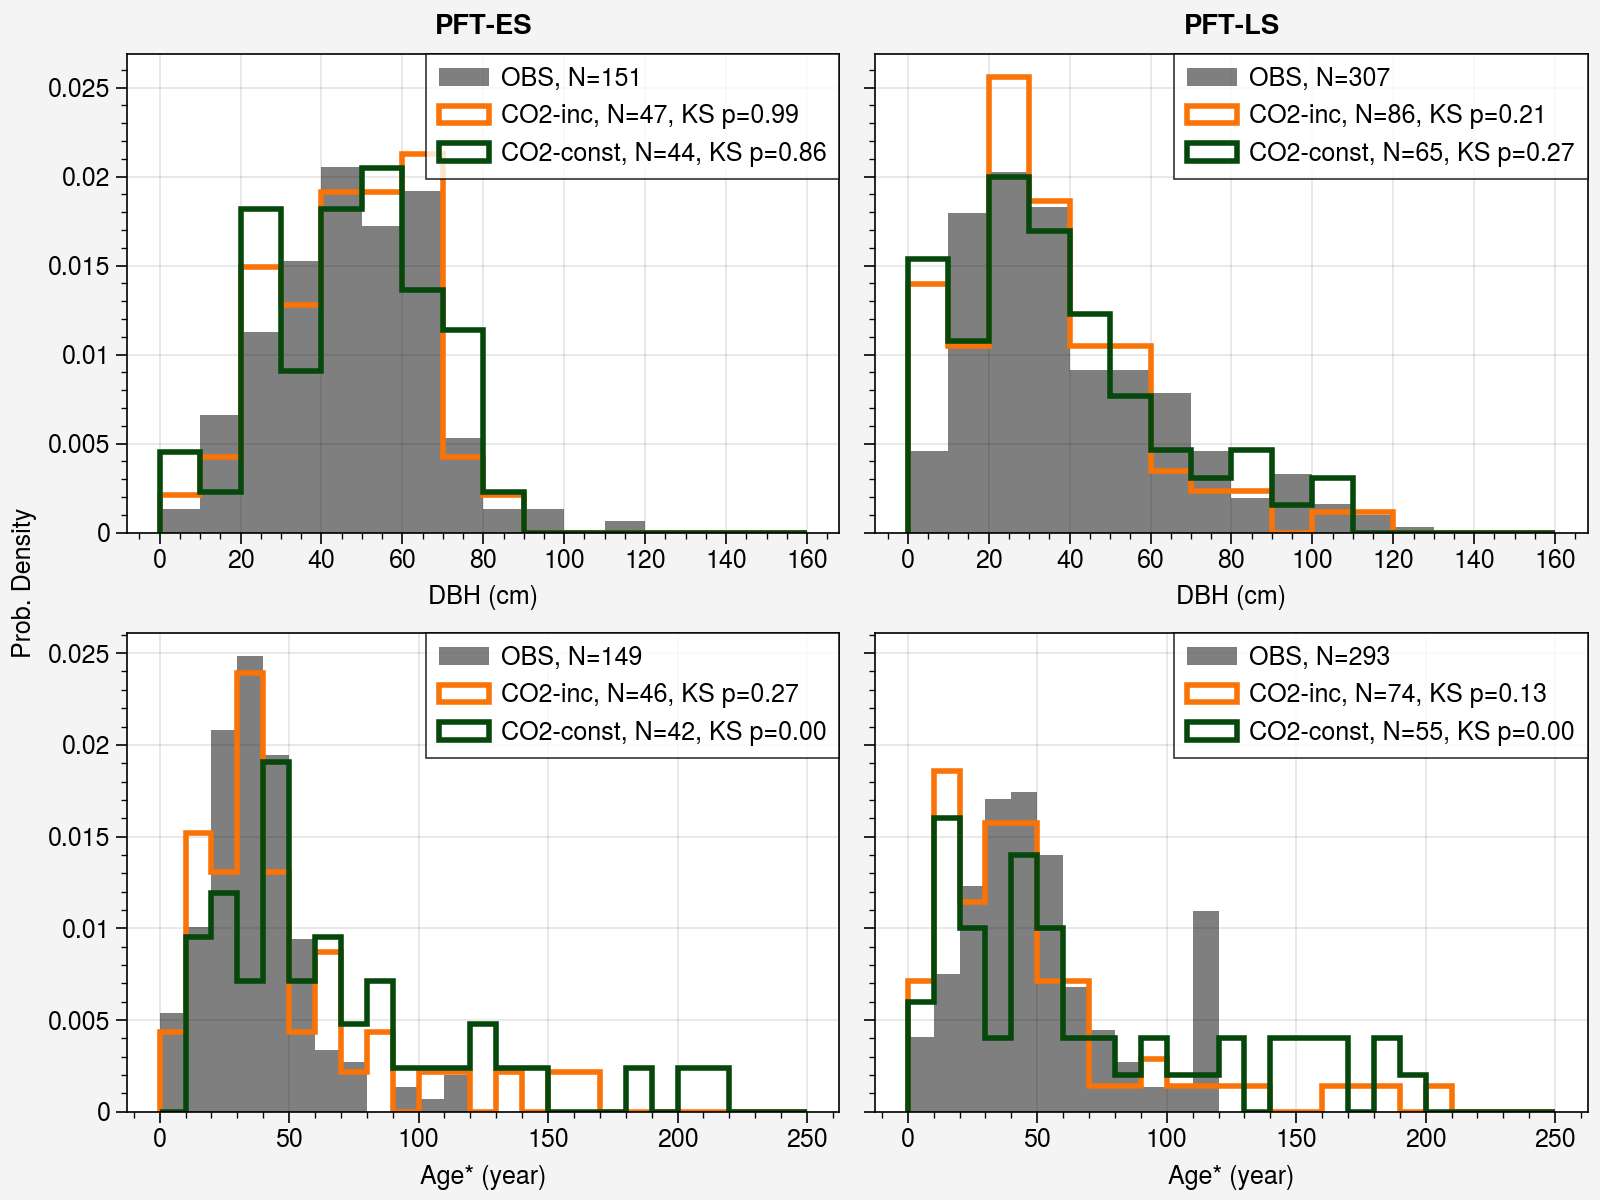

In [95]:
# %%capture --no-stdout --no-display stderr_dump
fig, axes = pplt.subplots(nrows=2,ncols=2,sharex=False,width=8,height=6)

year_str = '(Year == 2010)'
from scipy.stats import ks_2samp

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        
        if j == 0:
            pft_str = '(PFT == 2)'
        elif j == 1:
            pft_str = '(PFT == 4)'

        query_str = year_str + ' & ' + pft_str
        
        if i == 0:
            # first row, plot size distribution
            xs = []
            x = df_tr_obs.query(query_str).dbh.values
            xs.append(x)
            ax.hist(x,pplt.arange(0,161,10),density=True,color='k',alpha=0.5,label=f'OBS, N={len(x):d}')
            x = df_tr_inCO2.query(query_str).dbh.values
            xs.append(x)
            ax.hist(x,pplt.arange(0,161,10),density=True,histtype='step',color='xkcd:orange',
                    linewidth=2,label=f'CO2-inc, N={len(x):d}, KS p={ks_2samp(xs[0],xs[1])[1]:4.2f}')
            x = df_tr_exCO2.query(query_str).dbh.values
            xs.append(x)
            ax.hist(x,pplt.arange(0,161,10),density=True,histtype='step',color='xkcd:forest green',
                    linewidth=2,label=f'CO2-const, N={len(x):d}, KS p={ks_2samp(xs[0],xs[2])[1]:4.2f}')
            ax.legend(ncol=1,loc='ur')


        if i == 1:
            # second row, plot age distribution
            xs = []
            x = df_tr_obs.query(query_str).age_gt10.dropna().values
            xs.append(x)
            ax.hist(x,pplt.arange(0,250,10),density=True,color='k',alpha=0.5,label=f'OBS, N={len(x):d}')
            x = df_tr_inCO2.query(query_str).age_gt10.dropna().values
            xs.append(x)
            ax.hist(x,pplt.arange(0,250,10),density=True,histtype='step',color='xkcd:orange',
                    linewidth=2,label=f'CO2-inc, N={len(x):d}, KS p={ks_2samp(xs[0],xs[1])[1]:4.2f}')
            x = df_tr_exCO2.query(query_str).age_gt10.dropna().values
            xs.append(x)
            ax.hist(x,pplt.arange(0,250,10),density=True,histtype='step',color='xkcd:forest green',
                    linewidth=2,label=f'CO2-const, N={len(x):d}, KS p={ks_2samp(xs[0],xs[2])[1]:4.2f}')
            ax.legend(ncol=1,loc='ur')



axes[0,:].format(xlabel='DBH (cm)',ylabel='Prob. Density')
axes[1,:].format(xlabel='Age* (year)',ylabel='Prob. Density')
axes.format(toplabels=('PFT-ES','PFT-LS'))
fig.savefig('./Figures/FigS2.png',dpi=300)

KstestResult(statistic=0.06791602085388192, pvalue=0.9912519892512109)
KstestResult(statistic=0.09768211920529801, pvalue=0.8634032047156489)
KstestResult(statistic=0.12616468449359897, pvalue=0.2136758347622921)
KstestResult(statistic=0.1324981207717364, pvalue=0.27427729450386945)


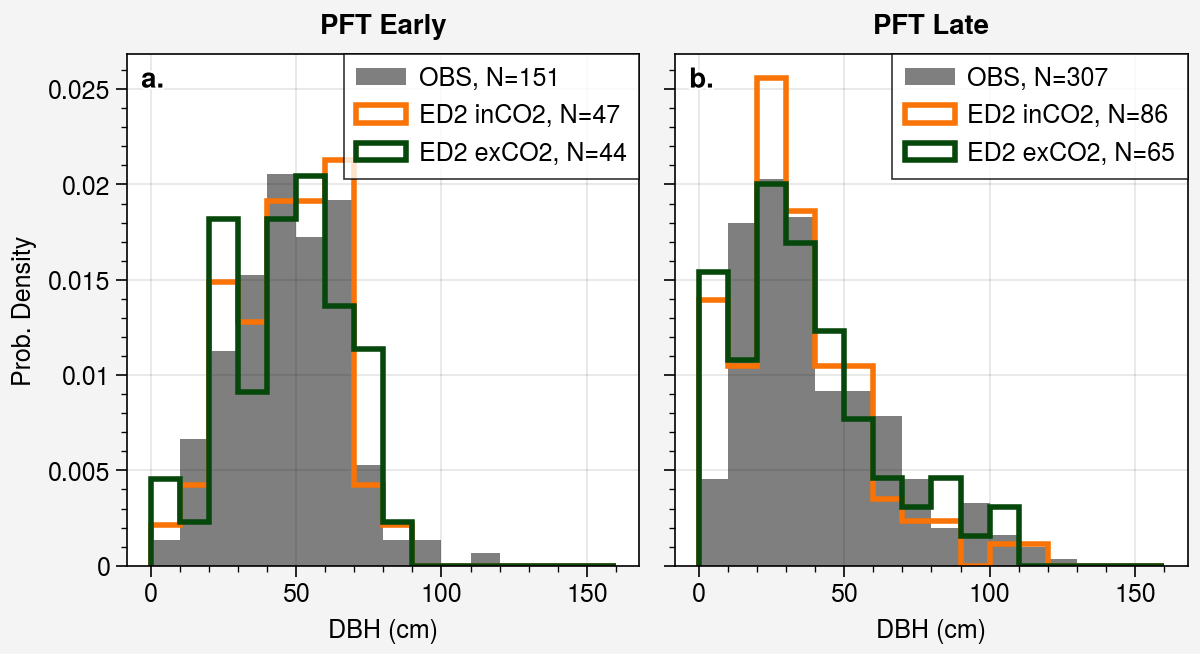

In [116]:
# %%capture --no-stdout --no-display stderr_dump
fig, axes = pplt.subplots(nrows=1,ncols=2,figwidth=6,sharex=False)

year_str = '(Year == 2010)'

for i in range(2):
    ax = axes[i]
    
    if i == 0:
        pft_str = '(PFT == 2)'
    elif i == 1:
        pft_str = '(PFT == 4)'

    query_str = year_str + ' & ' + pft_str
    
    xs = []
    x = df_tr_obs.query(query_str).dbh.values
    xs.append(x)
    ax.hist(x,pplt.arange(0,161,10),density=True,color='k',alpha=0.5,label=f'OBS, N={len(x):d}')
    x = df_tr_inCO2.query(query_str).dbh.values
    xs.append(x)
    ax.hist(x,pplt.arange(0,161,10),density=True,histtype='step',color='xkcd:orange',
            linewidth=2,label=f'ED2 inCO2, N={len(x):d}')
    x = df_tr_exCO2.query(query_str).dbh.values
    xs.append(x)
    ax.hist(x,pplt.arange(0,161,10),density=True,histtype='step',color='xkcd:forest green',
            linewidth=2,label=f'ED2 exCO2, N={len(x):d}')
    ax.legend(ncol=1,loc='ur')

    from scipy.stats import ks_2samp
    print(ks_2samp(xs[0],xs[1]))
    print(ks_2samp(xs[0],xs[2]))

axes.format(xlabel='DBH (cm)',ylabel='Prob. Density',toplabels=('PFT Early','PFT Late'),abc='a.',abcloc='ul')
        #     # plot obs
        #     df_tr_obs.query(query_str).dbh.plot.hist(bins=np.arange(0,161,10),density=True,ax=ax,
        #                                              color='k',alpha=0.5,label=f'OBS, N={df_tr_obs.query(query_str).shape[0]:d}')
        #     df_tr_inCO2.query(query_str).dbh.plot.hist(bins=np.arange(0,161,10),histtype='step',density=True,ax=ax,
        #                                              color='r',label=f'inCO2, N={df_tr_inCO2.query(query_str).shape[0]:d}',linewidth=2)
        #     df_tr_exCO2.query(query_str).dbh.plot.hist(bins=np.arange(0,161,10),histtype='step',density=True,ax=ax,
        #                                              color='b',label=f'exCO2, N={df_tr_exCO2.query(query_str).shape[0]:d}',linewidth=2)

        #     #ax.set_xlim([-5,150])
        #     #ax.set_xticks(np.arange(0,150,50))
        #     ax.set_ylim([0,0.06])
        #     ax.legend(loc='upper right',fontsize=7)
        #     ax.set_xlabel('DBH (cm)')
        #     ax.set_ylabel('Prob. Density')
        
        # elif j == 1:
        #     # second row, plot age distribution
        #     df_tr_obs.query(query_str).age_gt10.plot.hist(bins=np.arange(0,250,10),density=True,ax=ax,
        #                                              color='k',alpha=0.5,label=f'OBS, med={df_tr_obs.query(query_str).age_gt10.median():3.0f}')
        #     df_tr_inCO2.query(query_str).age_gt10.plot.hist(bins=np.arange(0,250,10),histtype='step',density=True,ax=ax,
        #                                              color='r',label=f'inCO2, med={df_tr_inCO2.query(query_str).age_gt10.median():3.0f}',linewidth=2)
        #     df_tr_exCO2.query(query_str).age_gt10.plot.hist(bins=np.arange(0,250,10),histtype='step',density=True,ax=ax,
        #                                              color='b',label=f'exCO2, med={df_tr_exCO2.query(query_str).age_gt10.median():3.0f}',linewidth=2)
         


81.2251538909856 1.938917260802944 397.47796953278674
155.13623690593568 1.2877623133663978 224.31478411723296
80.50036056726188 1.433708499241495 191.2242307577911
54.60434750929471 2.9891237845030405 15330.484702662268
70.90266215895652 1.6216220630146967 360.32571971380474
49.19123656892219 1.7113452527878665 396.1640643814897
[-0.54160853]
[0.9317991]
[0.45659873]
[-1.22438276]
[-0.19180112]
[-0.11944861]


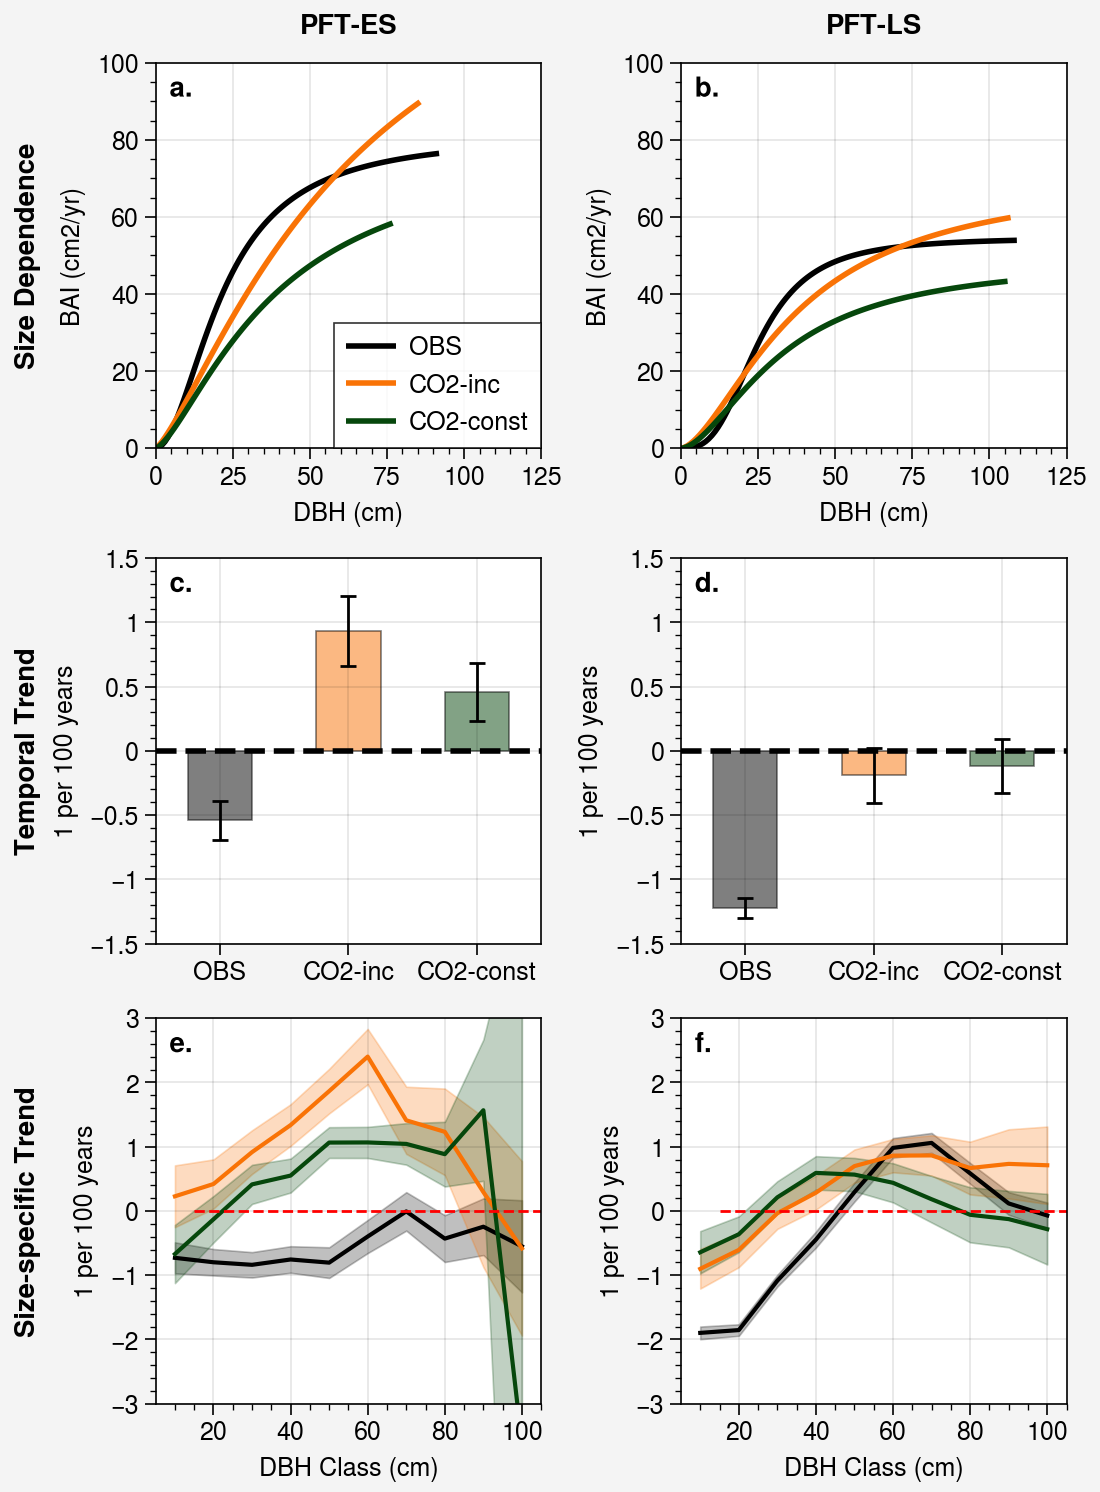

In [96]:
# bin into two PFTs
# loop over each sp to generate a GAM model
PFT_list = [2,4]
dbh_max = []
popts = []

labels = ['OBS','CO2-inc','CO2-const']
colors = ['k','xkcd:orange','xkcd:forest green']
yeara,yearz = 1950,2010


fig, axes = pplt.subplots(ncols=2,nrows=3,sharey=False, sharex=False,figwidth=5.5)
# first row, growth-size relationship
for i, ax in enumerate(axes[0,:]):
    # loop over species
    pft = PFT_list[i]
    
    for _i, _df in enumerate([df_tr_obs, df_tr_inCO2, df_tr_exCO2]):
        df_sp = _df.query(f'PFT == {pft} & Year >= {yeara}')[['dbh','BAI']]
        # add regression line
        dbh_max = np.nanpercentile(df_sp.dbh.values,99.)

        popt, pcov = curve_fit(GMM,
                df_sp.dropna()[['dbh']].values.ravel()
                ,df_sp.dropna()[['BAI']].values.ravel()
                ,bounds=([0,0,1],[10000,10,100000]))
        
        popts.append(popt)

        dbh_range = np.arange(1,dbh_max)
        a,b,k = popt
        print(a,b,k)
        #bai_predict = _gam.predict(dbh_range)
        bai_predict = GMM(dbh_range,a,b,k)
        hs = []
        h, = ax.plot(dbh_range,bai_predict,c=colors[_i],lw=2.,label=labels[_i])
        hs.append(h)

    
   
    if i == 0:
        ax.legend(ncols=1,loc='lr')




axes[0,:].format(xlim=(0,125),ylim=(0.,100),xlabel='DBH (cm)', ylabel='BAI (cm2/yr)')

# second row
# Temporal trend
dbh_str = "dbh >= 5 & dbh < 200"
for i, ax in enumerate(axes[1,:]):
    # loop over species
    PFT = pft_list[i]

    x_pos = np.array([0])
    width = 1.0
    for i_, df_ in enumerate([df_tr_obs,df_tr_inCO2,df_tr_exCO2]):
        year_mask = df_.Year > yeara
        sp_mask = df_.PFT == PFT
        y_mask = df_.BAI > 0.
        df_sp = df_[sp_mask & y_mask & year_mask]
        #print(df_sp.shape)

        # standardize the growth
        df_sp_rcs, popt, popt_ma = std_tr(df_sp)

               # regression

        reg_x = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").Year.values
        reg_y = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").BAI_rcs.values
        reg_mask = np.isfinite(reg_x) & np.isfinite(reg_y)
        reg_res = sm.OLS(reg_y,sm.add_constant(reg_x)).fit()

        y_val = reg_res.params[1:2] * 100.
        bardata = np.reshape(reg_res.conf_int()[1,:],(2,-1)) * 100.
        #h = ax.bar(x_pos,y_val,width=width,alpha=0.75)
        h = ax.bar(x_pos,y_val,bardata=bardata,width=width
                  ,facecolor=colors[i_],edgecolor='k',alpha=0.5)
        print(y_val)

        x_pos += 1
    
    ax.plot([-0.5,2.5],[0,0],c='k',ls='--',lw=2)


axes[1,:].format(ylabel='1 per 100 years',ylim=(-1.5,1.5),
                 xlocator=pplt.arange(3),xticklabels=labels,
                 xminorlocator='null')

# third row, moving window regression results
dbh_bins = np.arange(10,110,10)
dbh_width = 20 # 20cm bin
for i, ax in enumerate(axes[2,:]):
    # loop over species
    PFT = pft_list[i]

    for i_, df_ in enumerate([df_tr_obs,df_tr_inCO2,df_tr_exCO2]):
        year_mask = df_.Year > yeara
        sp_mask = df_.PFT == PFT
        y_mask = df_.BAI > 0.
        dbh_str = "dbh >= 5 & dbh < 200"
        df_sp = df_[sp_mask & y_mask & year_mask].query(dbh_str)

        # standardize the growth
        df_sp_rcs, popt, popt_ma = std_tr(df_sp)

        rcs_trend_list = []
        rcs_trend_ci_list = []
        for i_dbh, dbh_center in enumerate(dbh_bins):
            dbh_str = f'dbh >= {dbh_center-dbh_width} & dbh < {dbh_center + dbh_width}'

            # regression

            reg_x = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").Year.values
            reg_y = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").BAI_rcs.values

            if len(reg_y) < 5:
                rcs_trend_list.append(np.nan)
                rcs_trend_ci_list.append([np.nan,np.nan])
                continue
            reg_mask = np.isfinite(reg_x) & np.isfinite(reg_y)
            reg_res = sm.OLS(reg_y,sm.add_constant(reg_x)).fit()

            rcs_trend_list.append(reg_res.params[1])
            rcs_trend_ci_list.append(reg_res.conf_int()[1,:])

        # plot the slope
        rcs_trend_list = np.array(rcs_trend_list) * 100 # convert to century
        rcs_trend_ci_list = np.array(rcs_trend_ci_list) * 100 # convert to century
        #ax.scatter(dbh_bins,rcs_trend_list,c=colors[i_],bardata=rcs_trend_ci_list.T,labels=labels[i_])
        h = ax.plot(dbh_bins,rcs_trend_list,c=colors[i_],label=labels[i_])
        if i == 1:
            hs.append(h)
        ax.area(dbh_bins,rcs_trend_ci_list[:,0],rcs_trend_ci_list[:,1],c=colors[i_],alpha=0.25)
    
    ax.plot([15,105],[0,0],c='r',ls='--',lw=1)

axes[2,:].format(xlabel='DBH Class (cm)',ylabel='1 per 100 years',xlim=(5,105),ylim=(-3,3))

axes.format(abc='a.',abcloc='ul',
            toplabels=('PFT-ES','PFT-LS'),
            leftlabels=('Size Dependence','Temporal Trend','Size-specific Trend'))
fig.savefig('./Figures/Fig3.png',dpi=300)
fig.savefig('./Figures/Fig3.tiff',dpi=300)

X   -0.588101
dtype: float64
X    0.338193
dtype: float64
X   -0.030354
dtype: float64
X   -1.712589
dtype: float64
X   -0.012047
dtype: float64
X   -0.261262
dtype: float64


/ibstorage/utils/miniconda3/envs/share/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


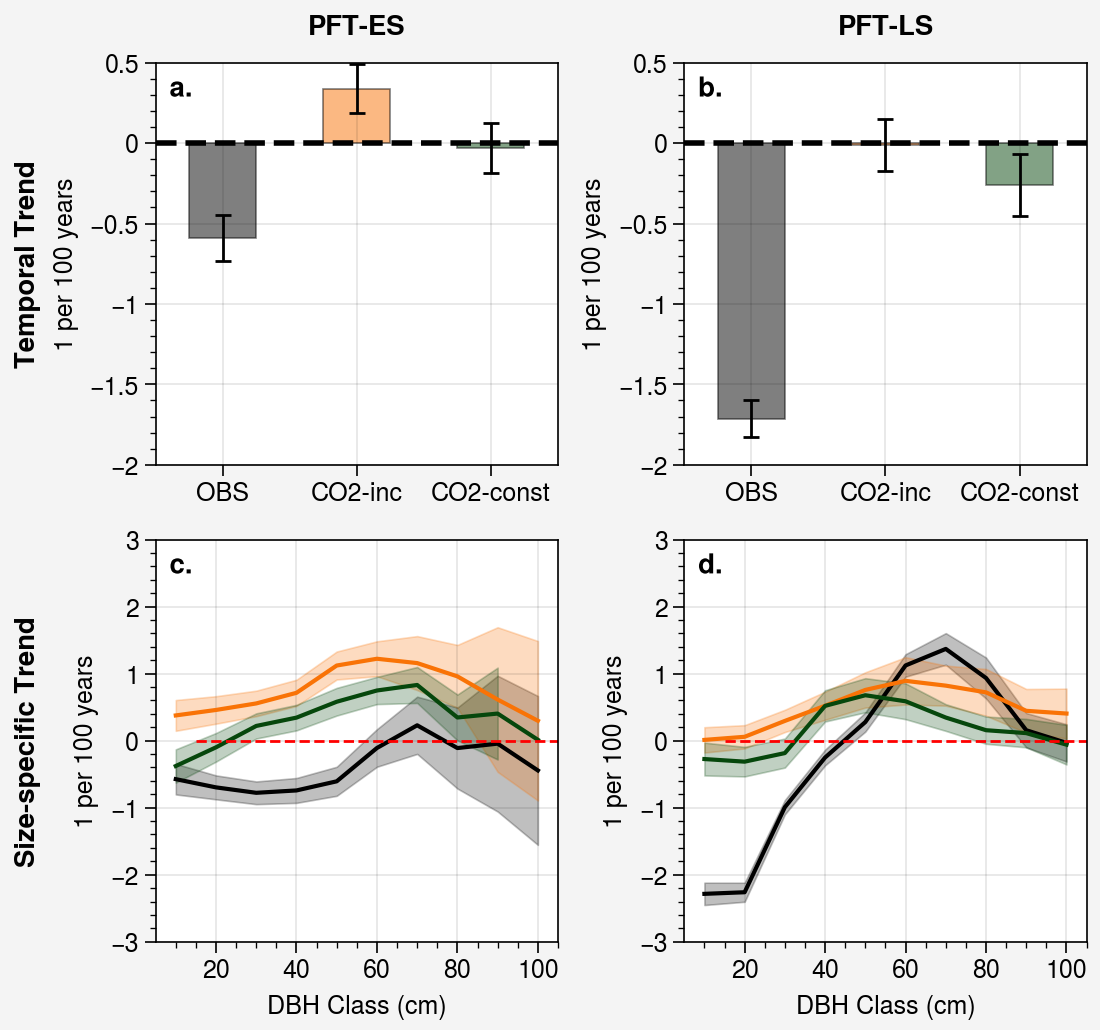

In [97]:
# supplementary figure, trend analysis using quantile regression

PFT_list = [2,4]
dbh_max = []
popts = []

labels = ['OBS','CO2-inc','CO2-const']
colors = ['k','xkcd:orange','xkcd:forest green']
yeara,yearz = 1950,2010


fig, axes = pplt.subplots(ncols=2,nrows=2,sharey=False, sharex=False,figwidth=5.5)

# Temporal trend
dbh_str = "dbh >= 5 & dbh < 200"
for i, ax in enumerate(axes[0,:]):
    # loop over species
    PFT = pft_list[i]

    x_pos = np.array([0])
    width = 1.0
    for i_, df_ in enumerate([df_tr_obs,df_tr_inCO2,df_tr_exCO2]):
        year_mask = df_.Year > yeara
        sp_mask = df_.PFT == PFT
        y_mask = df_.BAI > 0.
        df_sp = df_[sp_mask & y_mask & year_mask]
        #print(df_sp.shape)

        # standardize the growth
        df_sp_rcs, popt, popt_ma = std_tr(df_sp)

               # regression

        reg_x = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").Year.values
        reg_y = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").BAI_rcs.values
        reg_mask = np.isfinite(reg_x) & np.isfinite(reg_y)
        _df = pd.DataFrame({'Y' : reg_y[reg_mask],'X' : reg_x[reg_mask]})
        reg_res = smf.quantreg('Y ~ X',data=_df).fit(q=0.9) # 90% quantile

        y_val = reg_res.params[1:2] * 100.
        bardata = np.reshape(reg_res.conf_int().values[1,:],(2,-1)) * 100.
        #h = ax.bar(x_pos,y_val,width=width,alpha=0.75)
        h = ax.bar(x_pos,y_val,bardata=bardata,width=width
                  ,facecolor=colors[i_],edgecolor='k',alpha=0.5)
        print(y_val)

        x_pos += 1
    
    ax.plot([-0.5,2.5],[0,0],c='k',ls='--',lw=2)


axes[0,:].format(ylabel='1 per 100 years',ylim=(-2,0.5),
                 xlocator=pplt.arange(3),xticklabels=labels,
                 xminorlocator='null')

# third row, moving window regression results
dbh_bins = np.arange(10,110,10)
dbh_width = 20 # 20cm bin
for i, ax in enumerate(axes[1,:]):
    # loop over species
    PFT = pft_list[i]

    for i_, df_ in enumerate([df_tr_obs,df_tr_inCO2,df_tr_exCO2]):
        year_mask = df_.Year > yeara
        sp_mask = df_.PFT == PFT
        y_mask = df_.BAI > 0.
        dbh_str = "dbh >= 5 & dbh < 200"
        df_sp = df_[sp_mask & y_mask & year_mask].query(dbh_str)

        # standardize the growth
        df_sp_rcs, popt, popt_ma = std_tr(df_sp)

        rcs_trend_list = []
        rcs_trend_ci_list = []
        for i_dbh, dbh_center in enumerate(dbh_bins):
            dbh_str = f'dbh >= {dbh_center-dbh_width} & dbh < {dbh_center + dbh_width}'

            # regression

            reg_x = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").Year.values
            reg_y = df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}").BAI_rcs.values

            if len(reg_y) < 5:
                rcs_trend_list.append(np.nan)
                rcs_trend_ci_list.append([np.nan,np.nan])
                continue
            reg_mask = np.isfinite(reg_x) & np.isfinite(reg_y)
            _df = pd.DataFrame({'Y' : reg_y[reg_mask],'X' : reg_x[reg_mask]})
            reg_res = smf.quantreg('Y ~ X',data=_df).fit(q=0.9) # 90% quantile

            rcs_trend_list.append(reg_res.params.values[1])
            rcs_trend_ci_list.append(reg_res.conf_int().values[1,:])

        # plot the slope
        rcs_trend_list = np.array(rcs_trend_list) * 100 # convert to century
        rcs_trend_ci_list = np.array(rcs_trend_ci_list) * 100 # convert to century
        #ax.scatter(dbh_bins,rcs_trend_list,c=colors[i_],bardata=rcs_trend_ci_list.T,labels=labels[i_])
        h = ax.plot(dbh_bins,rcs_trend_list,c=colors[i_],label=labels[i_])
        if i == 1:
            hs.append(h)
        ax.area(dbh_bins,rcs_trend_ci_list[:,0],rcs_trend_ci_list[:,1],c=colors[i_],alpha=0.25)
    
    ax.plot([15,105],[0,0],c='r',ls='--',lw=1)

axes[1,:].format(xlabel='DBH Class (cm)',ylabel='1 per 100 years',xlim=(5,105),ylim=(-3,3))

axes.format(abc='a.',abcloc='ul',
            toplabels=('PFT-ES','PFT-LS'),
            leftlabels=('Temporal Trend','Size-specific Trend'))
fig.savefig('./Figures/Growth_Trend_quantreg.png',dpi=300)
#fig.savefig('./Figures/Fig3.tiff',dpi=300)

[-1.62572204e+03  9.36670739e-01 -7.89992019e-01]
[1.47405723e-25 8.64022733e-31 1.16640060e-12]
[-1.36200863e+03  8.14541627e-01 -4.60531454e-02]
[9.38068434e-32 4.18158433e-36 3.68566460e-01]
[ 2.69613808e+02 -2.73054832e-02 -4.35466642e-03]
[9.03455451e-05 3.93486204e-01 9.31062378e-01]
[-1.35465683e+03  7.99309410e-01 -1.25377889e+00]
[2.78654968e-18 5.44163563e-23 2.82434475e-21]
[-1.22614823e+03  7.46011728e-01 -1.27739216e-01]
[3.09341298e-42 6.54568333e-49 4.27045307e-03]
[ 3.87931025e+02 -8.77511121e-02 -4.00641592e-02]
[1.54670092e-10 8.56296050e-04 3.76634896e-01]
[95.83437396]
[81.5669989]
[-2.73054832]
[82.56444914]
[75.64875426]
[-8.93602373]


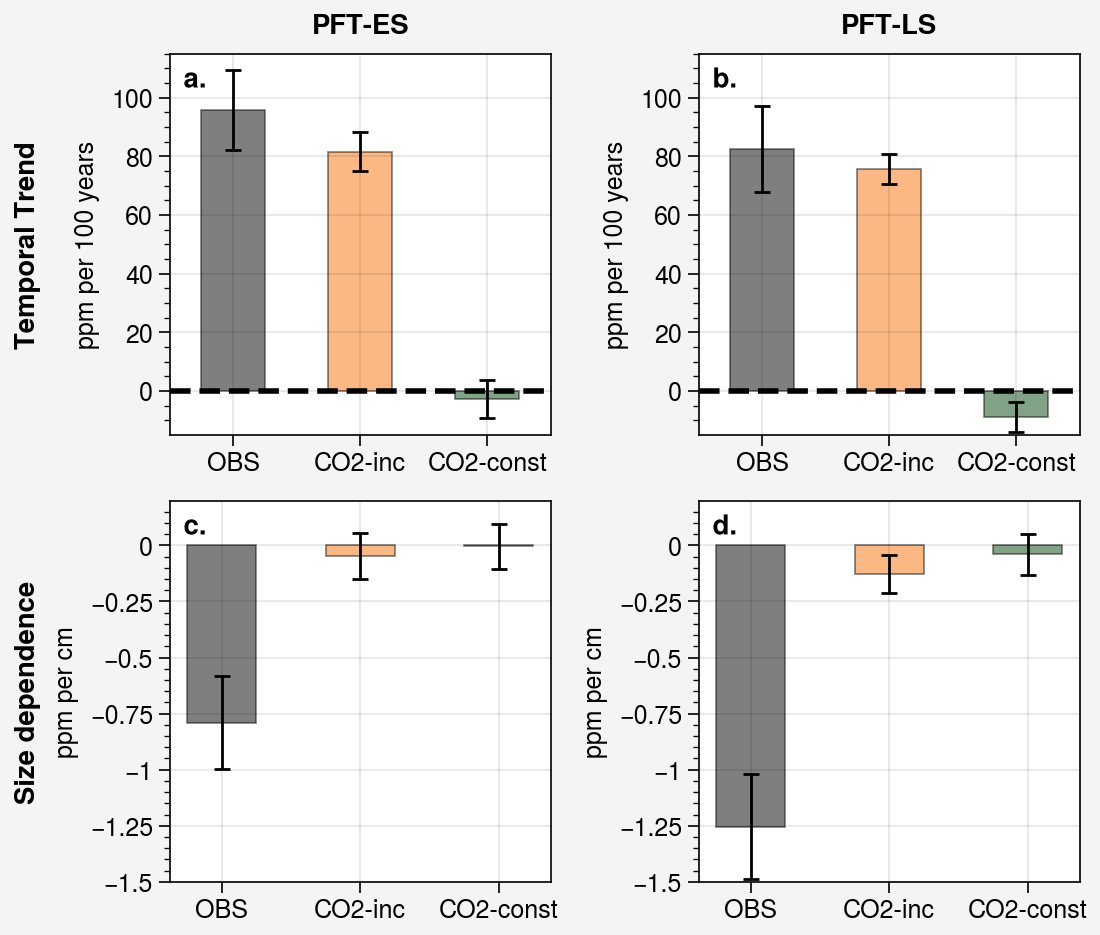

In [99]:
# Size dependence and temporal trend of Ci
# Main figure
# Trend of Ci
# Trend of Growth
# Size-specific trend of growth
pft_list = [2,4]

labels = ['OBS','CO2-inc','CO2-const']
colors = ['k','xkcd:orange','xkcd:forest green']



fig, axes = pplt.subplots(ncols=2,nrows=2,sharex=False,sharey=False,figwidth=5.5)
# first row, growth, all data, scatter plot
hs = []
# first row, Ci Trend
# only inclue 1950 to 2010
yeara,yearz = 1950,2010
dbh_str = "dbh >= 5 & dbh < 30"
ci_dbh_str = '(((dbh > 5) & (dbh < 10)) | ((dbh > 25) & (dbh < 30)))'

# side dependence second
for i, ax in enumerate(axes[1,:]):
    # loop over species
    pft = PFT_list[i]
    query_str = f'Year >= 1950 & PFT == {pft}'

    x_pos = np.array([0])
    width = 1.0
    for i_, df_ in enumerate([df_C13,df_Ci_inCO2,df_Ci_exCO2]):

        Y = df_.query(query_str).Ci.values
        X = df_.query(query_str)[['Year','dbh']].values

        reg_mask =  np.isfinite(Y)
        reg_res = sm.OLS(Y,sm.add_constant(X)).fit()

        print(reg_res.params)
        print(reg_res.pvalues)

        y_val = reg_res.params[2:3]
        bardata = np.reshape(reg_res.conf_int()[2,:],(2,-1))
        #h = ax.bar(x_pos,y_val,width=width,alpha=0.75)
        h = ax.bar(x_pos,y_val,bardata=bardata,width=width
                  ,facecolor=colors[i_],edgecolor='k',alpha=0.5) 

        x_pos += 1


axes[1,:].format(ylim=(-1.5,0.2),ylabel='ppm per cm',
                 xlocator=pplt.arange(0,3),xticklabels=labels,xminorlocator='null')


# trend first
for i, ax in enumerate(axes[0,:]):
    # loop over species
    PFT = pft_list[i]

    x_pos = np.array([0])
    width = 1.0
    for i_, df_ in enumerate([df_C13,df_Ci_inCO2,df_Ci_exCO2]):
        year_mask = df_.Year > yeara
        sp_mask = df_.PFT == PFT
        y_mask = df_.Ci > 0.
        df_sp = df_[sp_mask & y_mask & year_mask]

        # regression
        reg_x = df_sp.query(f"Year >= {yeara} & {ci_dbh_str}")[['Year','dbh']].values
        reg_y = df_sp.query(f"Year >= {yeara} & {ci_dbh_str}").Ci.values
        reg_mask = np.isfinite(reg_x[:,0]) & np.isfinite(reg_y)
        reg_res = sm.OLS(reg_y,sm.add_constant(reg_x)).fit()

        y_val = reg_res.params[1:2] * 100.
        bardata = np.reshape(reg_res.conf_int()[1,:],(2,-1)) * 100.
        #h = ax.bar(x_pos,y_val,width=width,alpha=0.75)
        h = ax.bar(x_pos,y_val,bardata=bardata,width=width
                  ,facecolor=colors[i_],edgecolor='k',alpha=0.5) 
        print(y_val)
        x_pos += 1
    
    ax.plot([-0.5,2.5],[0,0],c='k',ls='--',lw=2)

axes[0,:].format(ylabel='ppm per 100 years',ylim=(-15,115),
                 xlocator=pplt.arange(3),xticklabels=labels,
                 xminorlocator='null')

axes.format(abc='a.',abcloc='ul',
            toplabels=('PFT-ES','PFT-LS'),
            leftlabels=('Temporal Trend','Size dependence'))
# Note that if all simulated data is included, model has a significant size effect

fig.savefig('./Figures/Fig4.png',dpi=300)
fig.savefig('./Figures/Fig4.tiff',dpi=300)

3.2 Sensitivity Analysis

In [40]:
# climate data

date1 = datetime.datetime.fromisoformat('1800-01-01')
date2 = datetime.datetime.fromisoformat('2011-12-31')
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_ATM_TEMP_PY.mean(dim=['hour']).values
TAVG = np.reshape(y,(-1,12)).mean(axis=1) - 273.15
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_PCPG_PY.mean(dim=['hour']).values
PRCP = np.reshape(y,(-1,12)).mean(axis=1) * 86400 * 365
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_ATM_CO2_PY.mean(dim=['hour']).values
aCO2 = np.reshape(y,(-1,12)).mean(axis=1)


met_year = np.arange(1800,2011+1,1)

In [41]:
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_PCPG_PY.mean(dim=['hour']).values
# dry season is defined as last Novem to this April, following Vlam et al.
PRCP_dry = ( y[0::12] * 31 
             + y[1::12] * 28 
             + y[2::12] * 31
             + y[3::12] * 30
             + np.concatenate([[0],y[10::12][0:-1]]) * 30
             + np.concatenate([[0],y[11::12][0:-1]]) * 31
           )

PRCP_dry = PRCP_dry * 86400
PRCP_wet = np.reshape(y,(-1,12))[:,4:10].mean(axis=1) * 86400 * (31+30+31+31+30+31)



In [42]:
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_ATM_RSHORT_PY.mean(dim=['hour']).values
RSHORT = np.reshape(y,(-1,12)).mean(axis=1)
RSHORT_wet = np.reshape(y,(-1,12))[:,4:10].mean(axis=1)


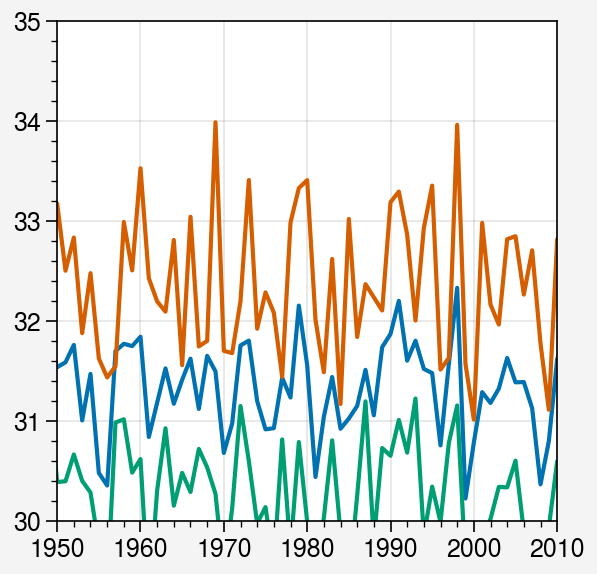

In [43]:
# TMAX
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_ATM_TEMP_PY.max(dim=['hour']).values
TMAX = np.reshape(y,(-1,12)).mean(axis=1) - 273.15

# TMAX_dry
TMAX_dry = np.array([ y[0::12],
              y[1::12], 
              y[2::12],
              y[3::12],
              np.concatenate([[0],y[10::12][0:-1]]),
              np.concatenate([[0],y[11::12][0:-1]]),
                    ])
TMAX_dry = np.nanmean(TMAX_dry,axis=0) - 273.15
TMAX_wet = np.reshape(y,(-1,12))[:,4:10].mean(axis=1) - 273.15

fig = pplt.figure()
ax = fig.add_subplot(111)
ax.plot(met_year,TMAX)
ax.plot(met_year,TMAX_dry)
ax.plot(met_year,TMAX_wet)
ax.format(xlim=(1950,2010),ylim=(30,35))

In [73]:
#GPP sensitivity to Ca
date1 = datetime.datetime.fromisoformat('1950-01-01')
date2 = datetime.datetime.fromisoformat('2010-12-31')
sim_gpp_inCO2 = sim_data_py[0]['MMEAN_GPP_PY'].sel(time=slice(date1,date2)).values.reshape((-1,12)).mean(axis=1)
sim_gpp_exCO2 = sim_data_py[1]['MMEAN_GPP_PY'].sel(time=slice(date1,date2)).values.reshape((-1,12)).mean(axis=1)

sim_lai_inCO2 = sim_data_py[0]['MMEAN_LAI_PY'].sel(time=slice(date1,date2)).sum(dim=['size','pft']).values.reshape((-1,12)).mean(axis=1)
sim_lai_exCO2 = sim_data_py[1]['MMEAN_LAI_PY'].sel(time=slice(date1,date2)).sum(dim=['size','pft']).values.reshape((-1,12)).mean(axis=1)

In [136]:
df_gpp_reg = pd.DataFrame({'GPP_inCO2' : sim_gpp_inCO2 / sim_lai_inCO2,
                           'GPP_exCO2' : sim_gpp_exCO2 / sim_lai_exCO2,
                           'aCO2'      : aCO2[-61::],
                           'PDRY'      : PRCP_dry[-61::],
                           'TMAX'      : TMAX[-61::]})


In [137]:
smf.ols('np.log(GPP_inCO2) ~ np.log(aCO2)+PDRY+TMAX',data=df_gpp_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(GPP_inCO2)   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     15.27
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           2.09e-07
Time:                        23:46:31   Log-Likelihood:                 96.771
No. Observations:                  61   AIC:                            -185.5
Df Residuals:                      57   BIC:                            -177.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.7825      0.792     -3.514      0.001      -4.368      -1.197
np.log(aCO2)     0.6022      0.097      6.213      0.000       0.408       0.796
PDRY          3.495e-05   8.48e-05      0.412      0.682      -0.000       0.000
TMAX            -0.0324      0.016     -2.049      0.045      -0.064      -0.001
==============================================================================
Omnibus:                        3.326   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                2.405
Skew:                           0.416   Prob(JB):                        0.300
Kurtosis:                       3.505   Cond. No.                     2.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [144]:
smf.ols('np.log(GPP_exCO2) ~ np.log(aCO2)+TMAX+PDRY',data=df_gpp_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(GPP_exCO2)   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.050
Date:                Thu, 27 Jul 2023   Prob (F-statistic):              0.117
Time:                        00:11:36   Log-Likelihood:                 83.604
No. Observations:                  61   AIC:                            -159.2
Df Residuals:                      57   BIC:                            -150.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0597      0.983     -0.061      0.952      -2.027       1.908
np.log(aCO2)     0.1412      0.120      1.174      0.245      -0.100       0.382
TMAX            -0.0362      0.020     -1.841      0.071      -0.076       0.003
PDRY          2.534e-05      0.000      0.241      0.810      -0.000       0.000
==============================================================================
Omnibus:                        2.702   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                2.057
Skew:                           0.441   Prob(JB):                        0.357
Kurtosis:                       3.174   Cond. No.                     2.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [598]:
np.exp( 0.60 * (np.log(385) - np.log(285)))

1.197759217476761

In [602]:
# beta_gpp_ca in EucFACE
(np.log(1754+552) - np.log(1563 + 497)) / (np.log(380+150) - np.log(380))

0.3390636853983136

In [600]:
# beta values estimated by Walker et al.

betas = [-0.99,1,0.68,0.7,0.18,0.95,1.1,1.3,1.6,1.2,-0.39,-0.25,-0.29,0.8,1.2,
         0.53,0.014,0.73,1.6,0.57,0.98,0.31,0.78,0.72,0.5,-0.6,-1,-0.22,-0.28,1.2,
         0.98,1.6,1.4,1.3,1,0.67,0.85,1.1,1.2,1.5,1.2,0.73,0.87,-0.14,-0.38,0.027,-0.54,0.65,0.84,-0.49,
         0.28,3.9,2.4,-0.28,0.73]

In [601]:
np.nanmean(betas)

0.6549272727272726

In [603]:
np.nanstd(betas)

0.8428284599445856

3.3 CO2 Sensitivity analysis

In [101]:
# add climate information to dataframes

# climate data

date1 = datetime.datetime.fromisoformat('1800-01-01')
date2 = datetime.datetime.fromisoformat('2011-12-31')
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_ATM_TEMP_PY.mean(dim=['hour']).values
TAVG = np.reshape(y,(-1,12)).mean(axis=1) - 273.15
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_PCPG_PY.mean(dim=['hour']).values
PRCP = np.reshape(y,(-1,12)).mean(axis=1) * 86400 * 365
y = sim_data_py[0].sel(time=slice(date1,date2)).QMEAN_ATM_CO2_PY.mean(dim=['hour']).values
aCO2 = np.reshape(y,(-1,12)).mean(axis=1)
met_year = np.arange(1800,2011+1,1)

met_rean_df = pd.read_csv(f'./Data/met_annual.csv')

met_rean_df
# add Ca/prcp/tmp into all df_tr_rcs
# add 
dfs = [df_tr_obs,df_tr_inCO2,df_tr_exCO2,df_C13]
for _idf, df in enumerate(dfs):
    df = df.assign(Ca=np.nan)
    df = df.assign(rean_PRCP=np.nan)
    df = df.assign(rean_TAVG=np.nan)
    
    # loop over years to assign CO2
    for year in np.arange(1901,2010+1):
        if sum(df.Year == year) == 0:
            continue
        
        year_mask = df.Year == year
        df.loc[year_mask,'Ca'] = aCO2[met_year == year][0]
        df.loc[year_mask,'rean_PRCP'] = PRCP[met_year == year][0]
        df.loc[year_mask,'rean_TAVG'] = TAVG[met_year == year][0]
        df.loc[year_mask,'PRCP_dry']  = PRCP_dry[met_year == year][0]
        df.loc[year_mask,'PRCP_wet']  = PRCP_wet[met_year == year][0]
        df.loc[year_mask,'TMAX_dry']  = TMAX_dry[met_year == year][0]
        df.loc[year_mask,'TMAX_wet']  = TMAX_wet[met_year == year][0]
        df.loc[year_mask,'TMAX']  = TMAX[met_year == year][0]
        df.loc[year_mask,'TMAX']  = TMAX[met_year == year][0]
        
        
        #df.loc[year_mask,'rean_PRCP'] = met_rean_df.query(f'year == {year}').assi_PRCP.values[0]
        #df.loc[year_mask,'rean_TAVG'] = met_rean_df.query(f'year == {year}').assi_TAVG.values[0]

    dfs[_idf] = df

df_tr_obs = dfs[0]
df_tr_inCO2 = dfs[1]   
df_tr_exCO2 = dfs[2]   
df_C13 = dfs[3]   
        
    


0.04463201203103784
Intercept     19.338462
np.log(Ca)    -1.830354
PRCP_dry       0.000431
TMAX          -0.287383
dtype: float64
0.0667187073964215
Intercept    -1.897237
np.log(Ca)    2.121971
PRCP_dry      0.000863
TMAX         -0.349689
dtype: float64
0.0720553086210558
Intercept     7.770675
np.log(Ca)    0.959278
PRCP_dry      0.000707
TMAX         -0.438570
dtype: float64
np.log(Ca)   -1.830354
dtype: float64
np.log(Ca)    2.121971
dtype: float64
np.log(Ca)    0.959278
dtype: float64
PRCP_dry    0.043054
dtype: float64
PRCP_dry    0.086251
dtype: float64
PRCP_dry    0.070739
dtype: float64
TMAX   -0.287383
dtype: float64
TMAX   -0.349689
dtype: float64
TMAX   -0.43857
dtype: float64
0.05949059631691789
Intercept     11.762781
np.log(Ca)    -0.971947
PRCP_dry       0.001120
TMAX          -0.204450
dtype: float64
0.2528241784898264
Intercept    -1.723875
np.log(Ca)    2.784694
PRCP_dry      0.000816
TMAX         -0.478491
dtype: float64
0.27321992911512294
Intercept     1.544166


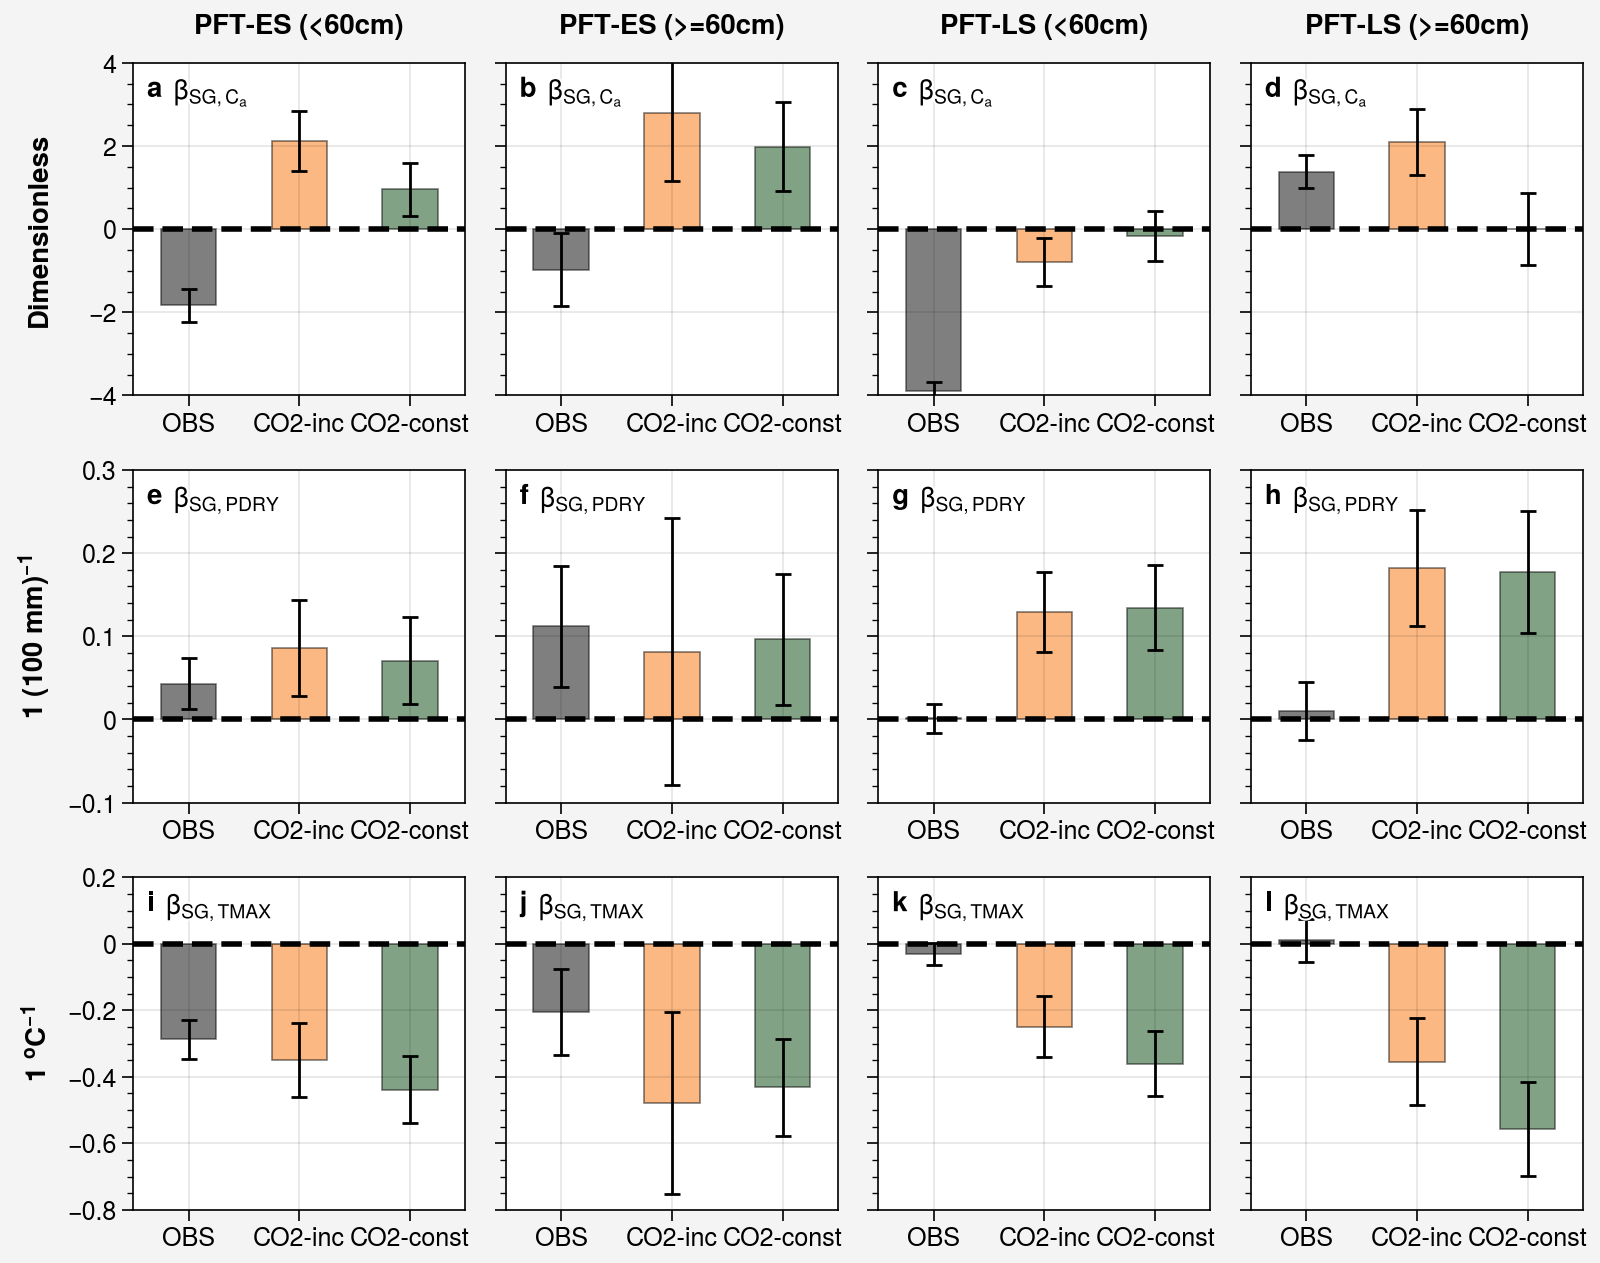

In [147]:
pft_list = [2,4]

labels = ['OBS','CO2-inc','CO2-const']
colors = ['k','xkcd:orange','xkcd:forest green']



fig, axes = pplt.subplots(ncols=4,nrows=3,sharex=False,sharey=True,figwidth=8.)
# first row, growth, all data, scatter plot
hs = []
# first row, Ci Trend
# only inclue 1950 to 2010
yeara,yearz = 1950,2010

# first column, PFT 2, all data together
dbh_strs = [
                "dbh >= 5 & dbh < 60",
                "dbh >= 5 & dbh >= 60",
                "dbh >= 5 & dbh < 60",
                "dbh >= 5 & dbh >= 60",
            ]
PFTs = [2,2,4,4]
rrs = []
for j in range(4):
    dbh_str = dbh_strs[j]
    PFT = PFTs[j]
    dfs = [] 
    _rrs = []
    for i_, df_ in enumerate([df_tr_obs,df_tr_inCO2,df_tr_exCO2]):
        year_mask = df_.Year > yeara
        sp_mask = df_.PFT == PFT
        y_mask = np.isfinite(df_.BAI)
        df_sp = df_[sp_mask & y_mask & year_mask]
        # standardize the growth
        df_sp_rcs, popt, popt_ma = std_tr(df_sp)

        # regression
        df_reg= df_sp_rcs.query(f"Year >= {yeara} & Year <= {yearz} & {dbh_str}")
        #reg_res = smf.ols(f'BAI_rcs ~ np.log(Ca) + rean_PRCP + rean_TAVG',data=df_reg).fit()
        reg_res = smf.ols(f'BAI_rcs ~ np.log(Ca) + PRCP_dry + TMAX',data=df_reg).fit()
        # result is consistent if precipitation is log-transformed

        print(reg_res.rsquared)
        print(reg_res.params)
        _rrs.append(reg_res)
        dfs.append(df_sp_rcs)
    scales = [1.,100.,1.]
    rrs.append(_rrs)

    for i, ax in enumerate(axes[:,j]):
        # loop over variables
        x_pos = np.array([0])
        width = 1.0
        for i_, reg_res in enumerate(_rrs):
            y_val = reg_res.params[(i+1):(i+2)] * scales[i]
            bardata = np.reshape(reg_res.conf_int().values[(i+1),:],(2,-1)) * scales[i]
            #h = ax.bar(x_pos,y_val,width=width,alpha=0.75)
            h = ax.bar(x_pos,y_val,bardata=bardata,width=width
                        ,facecolor=colors[i_],edgecolor='k',alpha=0.5) 
            print(y_val)
            x_pos += 1

        ax.plot([-0.5,2.5],[0,0],c='k',ls='--',lw=2)

axes[0,:].format(ylim=(-4,4),title=r'$\beta$$_{SG,C_a}$',titleloc='ul')
axes[1,:].format(ylim=(-0.1,0.3),title=r'$\beta$$_{SG,PDRY}$',titleloc='ul')
axes[2,:].format(ylim=(-0.8,0.2),title=r'$\beta$$_{SG,TMAX}$',titleloc='ul')
axes.format(xlocator=pplt.arange(3),xticklabels=labels,xminorlocator=[],
            abc='a',abcloc='ul',
            toplabels=(
                       'PFT-ES (<60cm)',
                       'PFT-ES (>=60cm)',
                       'PFT-LS (<60cm)',
                       'PFT-LS (>=60cm)'
                       ), 
            leftlabels=('Dimensionless',
                        '1 (100 mm)$^{-1}$',
                        '1 $^oC^{-1}$'))
fig.savefig('./Figures/Fig5.png',dpi=300)
fig.savefig('./Figures/Fig5.tiff',dpi=300)

In [103]:
c14f15_bs_tf = [0.0608,1.004478]
rho_dict = {'2' : 0.5, '4' : 0.75}
b1Ht_dict = {'2' : 1.589,'4':1.570}
b2Ht_dict = {'2' : 0.459, '4':0.442}

hite_fun = lambda dbh,pft : np.exp(b1Ht_dict[pft] + b2Ht_dict[pft] * np.log(np.minimum(120,dbh)))
agb_fun = lambda dbh,pft: c14f15_bs_tf[0] * rho_dict[pft] ** c14f15_bs_tf[1] * (dbh * dbh * hite_fun(dbh,pft)) ** c14f15_bs_tf[1]


b1_agb_dict = {
    '2' : c14f15_bs_tf[0] * (rho_dict['2'] * np.exp(b1Ht_dict['2'])) ** c14f15_bs_tf[1],
    '4' : c14f15_bs_tf[0] * (rho_dict['4'] * np.exp(b1Ht_dict['4'])) ** c14f15_bs_tf[1],
     }
b2_agb_dict = {
    '2' : (2 + b2Ht_dict['2']) * c14f15_bs_tf[1],
    '4' : (2 + b2Ht_dict['4']) * c14f15_bs_tf[1],
     }


In [104]:
# estimate allocational shift necessary to explain lack of growth
# rel_alloc = b0 + b1 * log(aCO2)
baseline_aCO2 = aCO2[met_year == 1950][0]
baseline_alloc = 0.  # start with log(1)


# first row, Ci Trend
# only inclue 1950 to 2010
yeara,yearz = 1950,2010
dbh_strs = [
                "dbh >= 5 & dbh < 60",
                "dbh >= 5 & dbh >= 60",
                "dbh >= 5 & dbh < 60",
                "dbh >= 5 & dbh >= 60",
            ]
PFTs = [2,2,4,4]

b1_alloc_array = np.arange(-8,0.1,0.5)
betas_array = []
betas_upper_array = []
betas_lower_array = []
for i in range(4):
    PFT = PFTs[i]
    dbh_str = dbh_strs[i]

    betas = []
    betas_upper = []
    betas_lower = []
    for j, b1_alloc in enumerate(b1_alloc_array):
        b0_alloc = baseline_alloc - b1_alloc * np.log(baseline_aCO2)

        # nudge the growth
        
        df_sp = df_tr_inCO2.copy().query(f'Year >= {yeara} & PFT == {PFT} & BAI > -999')
        #year_mask = df_.Year > yeara
        #sp_mask = df_.PFT == PFT
        #y_mask = np.isfinite(df_.BAI)
        #df_sp = df_[sp_mask & y_mask & year_mask]
        row_mask = df_sp.Year.values > 0
        # get ddbh
        
        df_sp.loc[row_mask,'DDBH'] = ((np.pi / 4. * (df_sp['dbh'].values) ** 2 + df_sp.BAI.values) / (np.pi / 4)) ** (0.5) - df_sp.dbh.values

        # get new ddbh
        biomass_init = b1_agb_dict[str(PFT)] * df_sp.dbh.values ** b2_agb_dict[str(PFT)]
        biomass_after = b1_agb_dict[str(PFT)] * (df_sp.dbh.values + df_sp.DDBH) ** b2_agb_dict[str(PFT)]
        biomass_delta = biomass_after - biomass_init
        biomass_delta_new = biomass_delta.copy()
        
        rel_alloc_years = np.exp(b0_alloc + b1_alloc * np.log(df_sp.Ca))
        biomass_delta_new *= (rel_alloc_years)
        
        # for year in aCO2_year:
        #     year_mask = df_sp.Year == year
        #     rel_alloc = rel_alloc_years[aCO2_year == year]
        #     biomass_delta_new[year_mask] *= (rel_alloc)

        _biomass_after = biomass_delta_new + biomass_init
        ddbh_new = (_biomass_after / b1_agb_dict[str(PFT)]) ** (1 / b2_agb_dict[str(PFT)]) - df_sp.dbh.values

        BAI_new = np.pi / 4. * ((df_sp['dbh'].values + ddbh_new) ** 2 - df_sp['dbh'].values ** 2)
        df_sp.loc[row_mask,'BAI'] = BAI_new

        # standardize the growth
        df_sp_rcs, popt, popt_ma = std_tr(df_sp)

        # regression
        df_reg= df_sp_rcs.query(f"Year >= {yeara} & {dbh_str}")
        reg_res = smf.ols(f'BAI_rcs ~ np.log(Ca) + PRCP_dry + TMAX',data=df_reg).fit()

        betas.append(reg_res.params[1])
        betas_lower.append(reg_res.conf_int().values[1,0])
        betas_upper.append(reg_res.conf_int().values[1,1])
        
    betas_array.append(betas)
    betas_lower_array.append(betas_lower)
    betas_upper_array.append(betas_upper)
    

In [105]:
# calculate the necessary beta to match the observations for each group
beta_alloc_high_array = []
beta_alloc_low_array = []
beta_alloc_mean_array = []
for i in range(4):
    # back-calculate the beta_alloc_target
    # get target beta
    
    # get the regression betweens betas_array and b1_alloc_array
    reg_beta = sm.OLS(betas_array[i],sm.add_constant(b1_alloc_array)).fit()
    
    
    PFT = PFTs[i]
    dbh_str = dbh_strs[i]

    df_sp_obs = df_tr_obs.copy().query(f'Year >= {yeara} & PFT == {PFT} & BAI > -999')
    
    df_sp_exCO2 = df_tr_exCO2.copy().query(f'Year >= {yeara} & PFT == {PFT} & BAI > -999')
    
    df_sp_inCO2 = df_tr_inCO2.copy().query(f'Year >= {yeara} & PFT == {PFT} & BAI > -999')
    
    
    # standardize the growth
    df_obs_rcs, popt, popt_ma = std_tr(df_sp_obs)
    df_exCO2_rcs, popt, popt_ma = std_tr(df_sp_exCO2)
    df_inCO2_rcs, popt, popt_ma = std_tr(df_sp_inCO2)

    # regression
    df_obs_reg= df_obs_rcs.query(f"Year >= {yeara} & {dbh_str}")
    reg_res = smf.ols(f'BAI_rcs ~ np.log(Ca) + PRCP_dry + TMAX',data=df_obs_reg).fit()
    
    df_exCO2_reg= df_exCO2_rcs.query(f"Year >= {yeara} & {dbh_str}")
    reg_exCO2_res = smf.ols(f'BAI_rcs ~ np.log(Ca) + PRCP_dry + TMAX',data=df_exCO2_reg).fit()
    
    df_inCO2_reg= df_inCO2_rcs.query(f"Year >= {yeara} & {dbh_str}")
    reg_inCO2_res = smf.ols(f'BAI_rcs ~ np.log(Ca) + PRCP_dry + TMAX',data=df_inCO2_reg).fit()
    
    delta_beta_growth = reg_res.conf_int().values[1,0] - (reg_inCO2_res.params[1] - reg_exCO2_res.params[1])
    delta_beta_alloc  = (delta_beta_growth) / reg_beta.params[1]
    beta_alloc_low_array.append(delta_beta_alloc)
    
    #alloc_shift_low = rel_alloc_fun(delta_beta_alloc,aCO2[-1]) * 100. - 100.
    
    delta_beta_growth = reg_res.conf_int().values[1,1] - (reg_inCO2_res.params[1] - reg_exCO2_res.params[1])
    delta_beta_alloc  = (delta_beta_growth) / reg_beta.params[1]
    beta_alloc_high_array.append(delta_beta_alloc)
    #alloc_shift_high = rel_alloc_fun(delta_beta_alloc,aCO2[-1]) * 100. - 100.
    
    delta_beta_growth = reg_res.params[1] - (reg_inCO2_res.params[1] - reg_exCO2_res.params[1])
    delta_beta_alloc  = (delta_beta_growth) / reg_beta.params[1]
    beta_alloc_mean_array.append(delta_beta_alloc)
    
    #print(delta_beta_growth,delta_beta_alloc,alloc_shift)


In [106]:
beta_alloc_mean_array

[-3.6450743174332554,
 -1.5726545061796098,
 -3.536029553669485,
 -0.8001810123660478]

In [107]:
# calculate NPP:GPP change in Jiang et al.
# Extended Data Fig. 7
N = 2000
GPP2NPPs_a = (np.random.randn(N) * 0.05 + 0.29) * (np.random.randn(N) * 0.03 + 0.20)
GPP2NPPs_e = (np.random.randn(N) * 0.02 + 0.35) * (np.random.randn(N) * 0.01 + 0.21)

beta_alloc_EucFace = (np.log(1./GPP2NPPs_a) - np.log(1./GPP2NPPs_e)) / (np.log(390) - np.log(390 + 150))


In [108]:
beta_gpp_EucFace = (np.log(1563+497) - np.log(1754+552)) / (np.log(390) - np.log(390 + 150))
print(beta_gpp_EucFace)


0.346652347517299


In [109]:
np.nanmean(beta_alloc_EucFace)

-0.7894320223166931

In [110]:
# calculate beta_alloc_Ca from regression coeffs
N = 2000
beta_alloc_Ca = [] # loop over four categories
params_idx = 1 # Ca
for i in range(len(rrs)):
    # beta_obs - (beta_co2_inc - beta_co2_fix)
    _rr = rrs[i][0]
    beta_obs = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    _rr = rrs[i][1]
    beta_inc = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    _rr = rrs[i][2]
    #beta_fix = _rr.params.values[params_idx]
    beta_fix = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    
    beta_alloc_Ca.append(beta_obs - (beta_inc - beta_fix))
    
beta_alloc_Ca = np.vstack(beta_alloc_Ca)

In [111]:
np.nanmean(beta_alloc_Ca,axis=1)

array([-2.99151295, -1.75519403, -3.25224303, -0.74273699])

In [112]:
# calculate beta_alloc_pdry and beta_alloc_tmax from regression coeffs
N = 2000
beta_alloc_pdry = [] # loop over four categories
params_idx = 2 # pdry
for i in range(len(rrs)):
    # beta_obs - (beta_co2_inc - beta_co2_fix)
    _rr = rrs[i][0]
    beta_obs = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    _rr = rrs[i][1]
    beta_inc = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    _rr = rrs[i][2]
    #beta_fix = _rr.params.values[params_idx]
    beta_fix = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    
    beta_alloc_pdry.append(beta_obs - beta_inc)
    
beta_alloc_pdry = np.vstack(beta_alloc_pdry)

beta_alloc_tmax = [] # loop over four categories
params_idx = 3 # tmax
for i in range(len(rrs)):
    # beta_obs - (beta_co2_inc - beta_co2_fix)
    _rr = rrs[i][0]
    beta_obs = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    _rr = rrs[i][1]
    beta_inc = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    _rr = rrs[i][2]
    #beta_fix = _rr.params.values[params_idx]
    beta_fix = np.random.randn(N) * _rr.bse.values[params_idx] + _rr.params.values[params_idx]
    
    beta_alloc_tmax.append(beta_obs - beta_inc)
    
beta_alloc_tmax = np.vstack(beta_alloc_tmax)

In [113]:
beta_alloc_pdry *= 100 # every 100mm

In [139]:
beta_alloc_Ca *= -1
beta_alloc_pdry *= -1
beta_alloc_tmax *= -1

In [141]:
beta_alloc_EucFace *= -1

0.04210106668783283
-0.027828056113806936
0.12769741154305825
0.17284652464259073
-0.06511505790555969
-0.2730304770030276
-0.21812640753809928
-0.36493739077417525


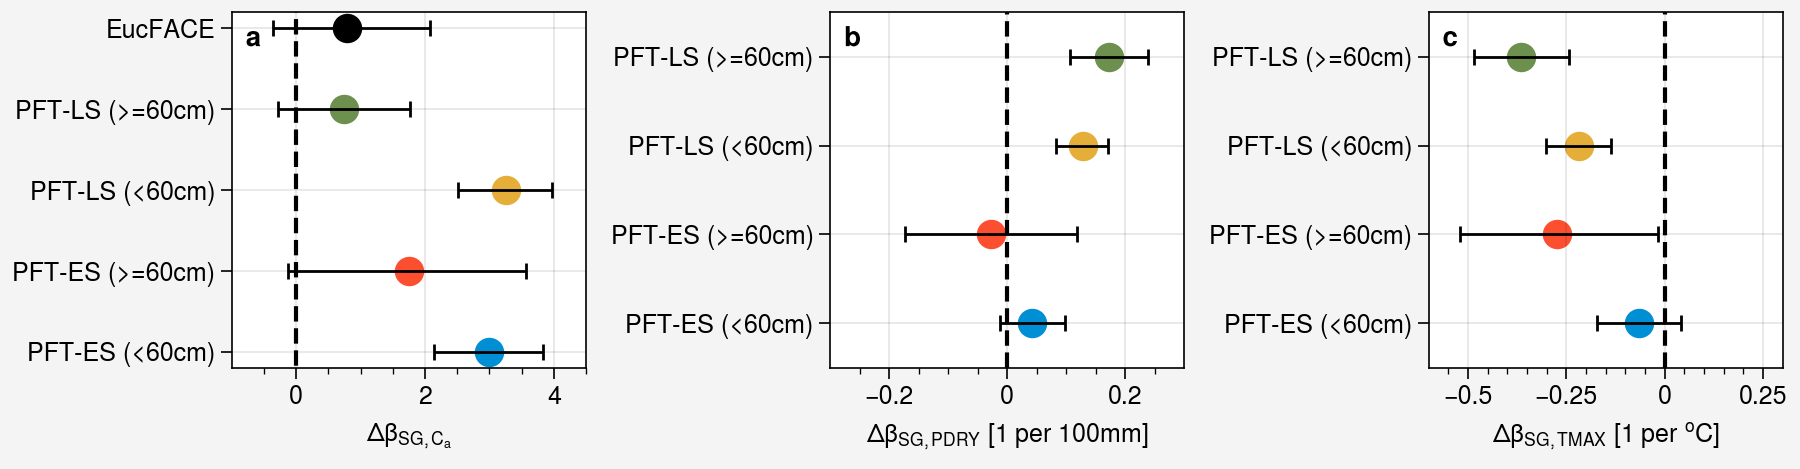

In [148]:
# schematic figure to show different beta_alloc
baseline_aCO2 = aCO2[met_year == 1950][0]
baseline_alloc = 0.  # start with log(1)

rel_alloc_fun = lambda b1_alloc, aCO2 : np.exp((baseline_alloc - b1_alloc * np.log(baseline_aCO2)) + b1_alloc * np.log(aCO2))

fig, axes = pplt.subplots(ncols=3,nrows=1,sharex=False,sharey=False,figwidth=9)

# comparison with field study
ax = axes[0]

# prepare data
for i in range(4):
    ax.scatterx(i,
               np.nanmean(beta_alloc_Ca[i,:]),
               s=100,
               bardata=np.percentile(beta_alloc_Ca[i,:],[5.,95.]).reshape((-1,1)),
               cycle='538')
    #print(np.nanmean(beta_alloc_Ca[i,:]))
ax.plot([0,0],[-1,10],'k--')
ax.scatterx(4,np.nanmean(beta_alloc_EucFace),s=100,c='k',
           bardata=np.percentile(beta_alloc_EucFace,[5.,95.]).reshape((-1,1)))
#print(np.nanmean(beta_alloc_EucFace))

ylabels=['PFT-ES (<60cm)',
        'PFT-ES (>=60cm)',
        'PFT-LS (<60cm)',
        'PFT-LS (>=60cm)',
        'EucFACE']
ax.format(yticks=range(5),yticklabels=ylabels,xlabel=r'$\Delta\beta_{SG,C_a}$',
          xlim=(-1,4.5),yminorlocator=[],ylim=(-0.2,4.2))


ax = axes[1]

# prepare data
for i in range(4):
    ax.scatterx(i,
               np.nanmean(beta_alloc_pdry[i,:]),
               s=100,
               bardata=np.percentile(beta_alloc_pdry[i,:],[5.,95.]).reshape((-1,1)),
               cycle='538')
    print(np.nanmean(beta_alloc_pdry[i,:]))

ax.plot([0,0],[-1,10],'k--')

ylabels=['PFT-ES (<60cm)',
        'PFT-ES (>=60cm)',
        'PFT-LS (<60cm)',
        'PFT-LS (>=60cm)']
ax.format(yticks=range(4),yticklabels=ylabels,xlabel=r'$\Delta\beta_{SG,PDRY}$ [1 per 100mm]',
          xlim=(-0.3,0.3),ylim=(-0.5,3.5),yminorlocator=[])


ax = axes[2] # tmax

# prepare data
for i in range(4):
    ax.scatterx(i,
               np.nanmean(beta_alloc_tmax[i,:]),
               s=100,
               bardata=np.percentile(beta_alloc_tmax[i,:],[5.,95.]).reshape((-1,1)),
               cycle='538')
    
    print(np.nanmean(beta_alloc_tmax[i,:]))

ax.plot([0,0],[-1,10],'k--')

ylabels=['PFT-ES (<60cm)',
        'PFT-ES (>=60cm)',
        'PFT-LS (<60cm)',
        'PFT-LS (>=60cm)']
ax.format(yticks=range(4),yticklabels=ylabels,xlabel=r'$\Delta\beta_{SG,TMAX}$ [1 per $^oC$]',
          xlim=(-0.6,0.3),ylim=(-0.5,3.5),yminorlocator=[])

axes.format(abc='a',abcloc='ul',)
fig.savefig('./Figures/Fig6.png',dpi=300)
fig.savefig('./Figures/Fig6.tiff',dpi=300)